#Thesis Title

Text Classification on Diabetes Mellitus Symptom and Treatment Documents Using Machine Learning Approaches

# Installation of Packages

In [ ]:
!pip install biopython
!pip install nltk
!pip install seaborn
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 12.5 MB/s eta 0:00:00


# Import Libraries

In [ ]:
# Import all required libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
import csv
import Bio
from Bio import Entrez
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from wordcloud import WordCloud
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
# Download required resources for NLTK
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

#Dataset Collection and Preparation

## Extract data from PubMed

In [ ]:
import Bio
from Bio import Entrez

# Provide email address to NCBI
Entrez.email = "phangyi@graduate.utm.my"

# Define your search terms
terms = ["Type 1 Diabetes Mellitus", "Type 2 Diabetes Mellitus", "Symptom", "Treatment"]
start_year = "2019"
end_year = "2024"

# Combine the search terms using the AND operator
search_term = " AND ".join(terms)

# Search for articles using the combined search term
handle = Entrez.esearch(db="pubmed", term=search_term, retmax=1020, mindate=start_year, maxdate=end_year)

# Fetch the list of article IDs
record = Entrez.read(handle)
id_list = record["IdList"]

# Create a list to store the extracted data
data = []

# Create a set to store the processed PMIDs
processed_pmids = set()

for pmid in id_list:
  if pmid in processed_pmids:
    continue

  try:
    handle = Entrez.efetch(db='pubmed', id=pmid, retmode='xml')
    article = Entrez.read(handle)['PubmedArticle'][0]
    handle.close()

    title = article['MedlineCitation']['Article']['ArticleTitle']
    abstract = article['MedlineCitation']['Article'].get('Abstract', {}).get('AbstractText', '')

    # Convert abstract to string
    abstract = str(abstract)

    # Append the extracted data to the list
    data.append({'Pmid': pmid, 'Title': title, 'Abstract': abstract})

  except Exception as e:
    print(f"Error occurred for PMID {pmid}: {str(e)}")
    continue

Error occurred for PMID 32809447: list index out of range


In [ ]:
import csv

# Save the data as CSV
csv_file = 'DM_articles.csv'
fieldnames = ['Pmid', 'Title', 'Abstract']

with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(data)

print(f'{len(data)} articles scraped and saved as {csv_file}.')


1019 articles scraped and saved as DM_articles.csv.


In [ ]:
from google.colab import files

# Download the CSV file
files.download("DM_articles.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data Preprocessing

### Importing Raw Dataset

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving DM_articles.csv to DM_articles.csv


In [ ]:
# Read the CSV file
df = pd.read_csv('DM_articles.csv')

# Print the first 5 rows
print(df.head())

       Pmid                                              Title  \
0  38718087  Surgery for carpal tunnel syndrome in patients...   
1  38692609  Patterns and predictors of female sexual dysfu...   
2  38680687  Are treatment options used for adult-onset typ...   
3  38676028  Physical Activity Detection for Diabetes Melli...   
4  38661109  Estimating the effect of lipid-lowering agents...   

                                            Abstract  
0  ['Carpal tunnel syndrome (CTS) occurs more oft...  
1  ['Background Sexual complications of people wi...  
2  ["Youth-onset type 2 diabetes mellitus (T2DM),...  
3  ['Diabetes mellitus (DM) is a persistent metab...  
4  [StringElement('The aims of the present study ...  


In [ ]:
df.shape

(1019, 3)

### Tokenize Abstracts to Sentences

In [ ]:
# Split abstract into sentences
sentences_list = []
for abstract in df["Abstract"]:
    sentences = nltk.sent_tokenize(str(abstract))
    sentences_list.extend(sentences)

# Create a new DataFrame with only the sentences column
sentences_df = pd.DataFrame(sentences_list, columns=["sentences"])

# Save the sentences DataFrame to a new CSV file
csv_file = 'sentences_dataset.csv'
sentences_df.to_csv(csv_file, index=False)

print(f'{len(sentences_list)} sentences saved as {csv_file}.')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


10804 sentences saved as sentences_dataset.csv.


In [ ]:
from google.colab import files

# Download the file
files.download("sentences_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(sentences_df.head(5))

                                           sentences
0  ['Carpal tunnel syndrome (CTS) occurs more oft...
1  The aim of this retrospective observational re...
2  Data on CTS diagnosis and surgery were collect...
3  A total of 35,105 individuals (age ≥ 18 years)...
4  Data were matched to the Swedish National Diab...


In [ ]:
sentences_df.shape

(10804, 1)

### Importing Sentences Dataset

In [ ]:
#Upload the sentences dataset
from google.colab import files

uploaded = files.upload()

Saving sentences_dataset.csv to sentences_dataset.csv


In [ ]:
# Load the CSV file
csv_file = "sentences_dataset.csv"
sentences_df = pd.read_csv(csv_file)

### Text Cleaning

In [ ]:
# Check for NaN values in 'sentences' column
nan_values = sentences_df['sentences'].isna().sum()

if nan_values > 0:
    print(f"There are {nan_values} rows of NaN values found in the 'sentences' column.")
else:
    print("No NaN values found in the 'sentences' column.")

There are 68 rows of NaN values found in the 'sentences' column.


In [ ]:
# Drop rows with NaN values in "sentences" column
sentences_df = sentences_df.dropna(subset=["sentences"])

In [ ]:
sentences_df.shape

(10736, 1)

In [ ]:
# Text preprocessing function
def preprocess_text(text):
    # Check if the value is NaN
    if pd.isnull(text):
        return ""

    # Convert text to lowercase
    text = text.lower()

    # Remove elements that start with "attributes={" and end with "})"
    text = re.sub(r"attributes=\{.*?\}\)", '', text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    #Remove HTML tags
    text = re.sub('<.*?>','',text)

    # Remove non-alphabetic characters
    text = re.sub("[^a-zA-Z]", ' ', text)

    # Remove elements that contain "StringElement"
    text = re.sub(r"stringelement", '', text)

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a string
    processed_text = " ".join(tokens)

    return processed_text


In [ ]:
# Apply preprocessing function to the "sentences" column
sentences_df["sentences"] = sentences_df["sentences"].apply(preprocess_text)

# Save the preprocessed data to a CSV file
sentences_df.to_csv("preprocessed_data.csv", index=False)

In [ ]:
# Download the CSV file
files.download("preprocessed_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Text Labelling

### Importing Cleaned Sentences Dataset

In [ ]:
#Upload the preprocessed dataset
from google.colab import files

uploaded = files.upload()

Saving preprocessed_data.csv to preprocessed_data.csv


In [ ]:
preprocessed_df = pd.read_csv('preprocessed_data.csv')

In [ ]:
preprocessed_df.shape

(10736, 1)

In [ ]:
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10736 entries, 0 to 10735
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentences  10165 non-null  object
dtypes: object(1)
memory usage: 84.0+ KB


In [ ]:
# Check for NaN values in the DataFrame
nan_values = preprocessed_df.isnull().sum()

# Print the number of NaN values for each column
print(nan_values)

sentences    571
dtype: int64


In [ ]:
# Check for null rows in the "sentences" column
null_rows = preprocessed_df[preprocessed_df["sentences"].isnull()]

# Print the specific rows with null values
print(null_rows["sentences"])

51       NaN
70       NaN
109      NaN
117      NaN
129      NaN
        ... 
10615    NaN
10624    NaN
10655    NaN
10668    NaN
10708    NaN
Name: sentences, Length: 571, dtype: object


In [ ]:
# Drop rows with NaN values in "sentences" column
preprocessed_df = preprocessed_df.dropna(subset=["sentences"])

# Reset the index
preprocessed_df = preprocessed_df.reset_index(drop=True)

In [ ]:
preprocessed_df.isna().sum()

sentences    0
dtype: int64

In [ ]:
preprocessed_df.shape

(10165, 1)

###Define Keywords

In [ ]:
# Define the symptoms and treatments
symptoms = [
    "high blood sugar",
    "hyperglycemia",
    "high glucose level",
    "weight loss",
    "weight gain",
    "thinner",
    "losing weight",
    "polyuria",
    "frequent urination",
    "urinating often",
    "peeing more often",
    "polyphagia",
    "hunger",
    "hungry",
    "increased hunger",
    "extreme hunger",
    "polydipsia",
    "thirst",
    "thirsty",
    "excessive thirst",
    "feeling more thirsty than usual",
    "fatigue",
    "feeling fatigued",
    "tired",
    "feeling tired",
    "dry skin",
    "itchy skin",
    "itching",
    "blurry vision",
    "blurred eyesight",
    "eyesight is blurred",
    "vision loss",
    "numb",
    "tingling",
    "slow healing sores",
    "slow in wound healing",
    "delayed wound healing",
    "cuts and wounds take longer to heal",
    "infections",
    "irritable",
    "mood changes",
    "depression",
    "depressive",
    "depressive mood"
]
treatments = [
    "pharmacology",
    "pharmacological treatment",
    "pharmacotherapy",
    "drugs",
    "oral drugs",
    "tablets",
    "medication",
    "psychology",
    "psychotherapy",
    "emotional support",
    "insulin",
    "diet",
    "diet monitoring",
    "healthy diet",
    "diet therapy",
    "blood sugar monitoring",
    "exercise",
    "physical activity"
]

In [ ]:
# Keyword preprocessing function
def preprocess_keyword(text):
    # Check if the value is NaN
    if pd.isnull(text):
        return ""

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a string
    processed_keyword = " ".join(tokens)

    return processed_keyword

# Preprocess the keywords using the preprocess_keyword function
symptoms = [preprocess_keyword(keyword) for keyword in symptoms]
treatments = [preprocess_keyword(keyword) for keyword in treatments]

In [ ]:
# Print the keywords
print("Preprocessed Symptoms Keywords:")
for keyword in symptoms:
    print(keyword)

print("\nPreprocessed Treatments Keywords:")
for keyword in treatments:
    print(keyword)

Preprocessed Symptoms Keywords:
high blood sugar
hyperglycemia
high glucose level
weight loss
weight gain
thinner
losing weight
polyuria
frequent urination
urinating often
peeing often
polyphagia
hunger
hungry
increased hunger
extreme hunger
polydipsia
thirst
thirsty
excessive thirst
feeling thirsty usual
fatigue
feeling fatigued
tired
feeling tired
dry skin
itchy skin
itching
blurry vision
blurred eyesight
eyesight blurred
vision loss
numb
tingling
slow healing sore
slow wound healing
delayed wound healing
cut wound take longer heal
infection
irritable
mood change
depression
depressive
depressive mood

Preprocessed Treatments Keywords:
pharmacology
pharmacological treatment
pharmacotherapy
drug
oral drug
tablet
medication
psychology
psychotherapy
emotional support
insulin
diet
diet monitoring
healthy diet
diet therapy
blood sugar monitoring
exercise
physical activity


### Function to Label Preprocessed Dataset

In [ ]:
preprocessed_df.head()

,sentences
0,carpal tunnel syndrome ct occurs often among i...
1,aim retrospective observational registry study...
2,data ct diagnosis surgery collected sk ne heal...
3,total individual age year diagnosed ct included
4,data matched swedish national diabetes registe...


In [ ]:
# Create a new dataframe for labelled data
labelled_data = pd.DataFrame()

In [ ]:
labelled_data['sentences'] = preprocessed_df['sentences']

In [ ]:
labelled_data.head()

,sentences
0,carpal tunnel syndrome ct occurs often among i...
1,aim retrospective observational registry study...
2,data ct diagnosis surgery collected sk ne heal...
3,total individual age year diagnosed ct included
4,data matched swedish national diabetes registe...


In [ ]:
labelled_data.shape

(10165, 1)

In [ ]:
labelled_data.isna().sum()

sentences    0
dtype: int64

In [ ]:
sentences = labelled_data['sentences']

# Create a new column for labels
labelled_data['label'] = 0

# Initialize dictionaries to store the matched symptom and treatment words for each sentence
symptom_words_dict = {}
treatment_words_dict = {}

# Define a function to get the n-gram of a keyword
def get_keyword_ngram(keyword):
    # Split the keyword by spaces and count the number of elements
    ngram = len(keyword.split())
    return ngram

# Loop through the sentences
for i, sentence in enumerate(sentences,0):
    # Tokenize the preprocessed sentence into words
    words = nltk.word_tokenize(sentence)

    if sentence != labelled_data.loc[i, 'sentences']:
        print(f"Sentence {i}: {sentence}")


    # Initialize flags for symptom and treatment
    symptom_flag = False
    treatment_flag = False

    # Initialize lists to store the matched symptom and treatment words for this sentence
    symptom_words_dict[i] = []
    treatment_words_dict[i] = []

    # Loop through the keywords
    for keyword in symptoms + treatments:
        # Preprocess the keyword and get the n-gram
        ngram = get_keyword_ngram(keyword)

        # Generate n-grams of the appropriate length
        sentence_ngrams = list(ngrams(words, ngram))

        # Check if the keyword is in the sentence n-grams
        for gram in sentence_ngrams:
            if keyword == ' '.join(gram):
                matched_word = ' '.join(gram)
                if keyword in symptoms:
                    symptom_flag = True
                    symptom_words_dict[i].append(matched_word)  # Store the matched word
                if keyword in treatments:
                    treatment_flag = True
                    treatment_words_dict[i].append(matched_word)  # Store the matched word

    # Assign labels
    if symptom_flag and treatment_flag:
        labelled_data.loc[i, 'label'] = 3
    elif symptom_flag:
        labelled_data.loc[i, 'label'] = 1
    elif treatment_flag:
        labelled_data.loc[i, 'label'] = 2
    elif not symptom_flag and not treatment_flag:
        labelled_data.loc[i, 'label'] = 0

In [ ]:
 labelled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10165 entries, 0 to 10164
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentences  10165 non-null  object
 1   label      10165 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 159.0+ KB


In [ ]:
labelled_data.head()

,sentences,label
0,carpal tunnel syndrome ct occurs often among i...,0
1,aim retrospective observational registry study...,0
2,data ct diagnosis surgery collected sk ne heal...,0
3,total individual age year diagnosed ct included,0
4,data matched swedish national diabetes registe...,0


In [ ]:
# Save the labelled data to a CSV file
labelled_data.to_csv("labelled_data.csv", index=False)

In [ ]:
from google.colab import files
# Download the CSV file
files.download("labelled_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Exploratory Data Analysis (EDA)

In [ ]:
eda_df = pd.read_csv('labelled_data.csv')

In [ ]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10165 entries, 0 to 10164
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentences  10165 non-null  object
 1   label      10165 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 159.0+ KB




### Bar Chart

In [ ]:
# Count the occurrences of each label and sort them by index
label_counts = eda_df['label'].value_counts().sort_index()

# Print the symptom counts
print("Label counts:")
print(label_counts)


Label counts:
label
0    8600
1     321
2    1187
3      57
Name: count, dtype: int64


<ipython-input-57-2880be2ef3a1>:23: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(bars, handles=legend_handles)


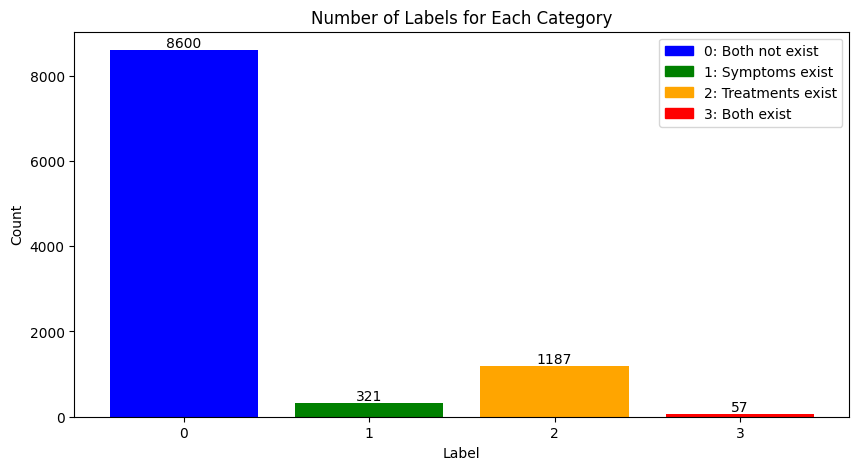

In [ ]:
# Define colors for each label
colors = ['blue', 'green', 'orange', 'red']

# Plot the label counts
plt.figure(figsize=(10, 5))
# Plotting the bar chart with different colors
bars = plt.bar(label_counts.index, label_counts.values, color=[colors[label] for label in label_counts.index])

# Add count annotations on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Number of Labels for Each Category')
plt.xticks(label_counts.index)

# Adding a legend with custom labels and sorted order
custom_labels = {0: '0: Both not exist', 1: '1: Symptoms exist', 2: '2: Treatments exist', 3: '3: Both exist'}
legend_handles = [mpatches.Patch(color=colors[label], label=custom_labels[label]) for label in label_counts.index]
plt.legend(bars, handles=legend_handles)

plt.show()

### Word Cloud

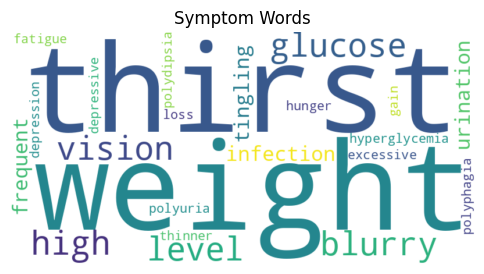

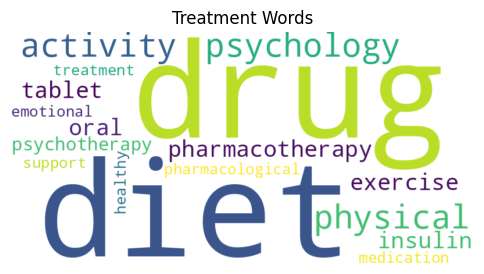

In [ ]:
# Flatten the symptom_words_dict and treatment_words_dict into a list
symptom_words_flat = [word for words in symptom_words_dict.values() for word in words]
treatment_words_flat = [word for words in treatment_words_dict.values() for word in words]

# Remove duplicate occurrences
symptom_words_unique = list(set(symptom_words_flat))
treatment_words_unique = list(set(treatment_words_flat))

# Generate word cloud for symptom and treatment words without duplicates
symptom_wordcloud_unique = WordCloud(width=800, height=400, background_color='white').generate(' '.join(symptom_words_unique))
treatment_wordcloud_unique = WordCloud(width=800, height=400, background_color='white').generate(' '.join(treatment_words_unique))

# Plot the updated word cloud
plt.figure(figsize=(6, 4))
plt.imshow(symptom_wordcloud_unique, interpolation='bilinear')
plt.title('Symptom Words')
plt.axis('off')
plt.show()

# Plot the updated word cloud
plt.figure(figsize=(6, 4))
plt.imshow(treatment_wordcloud_unique, interpolation='bilinear')
plt.title('Treatment Words')
plt.axis('off')
plt.show()

##Handle Imbalance Data

###Importing Labelled Dataset

In [ ]:
# import file
from google.colab import files
uploaded = files.upload()

Saving labelled_data.csv to labelled_data.csv


In [ ]:
import pandas as pd

# Load the preprocessed labeled data
labelled_data = pd.read_csv("labelled_data.csv")

### Resampling Data

- Label 0 (Both None Exist) will undergo undersampling, which will be reduced to 1565. Value of 1565 is obtaining from the calculation of total number of the other three labels.
- Label 3 (Both exists) category is removed due to it is the least found category in the dataset and does not provide significant impact to the models in achieving the research’s objectives.

In [ ]:
# Count the occurrences of each label
labelled_data['label'].value_counts()

label
0    8600
2    1187
1     321
3      57
Name: count, dtype: int64

In [ ]:
# Get the indices of rows where '0' column is 0 and other than 0
other = labelled_data[(labelled_data['label'] == 1) |
                           (labelled_data['label'] == 2) |
                           (labelled_data['label'] == 3)].index
none_1 = labelled_data[labelled_data['label'] == 0].index

# Display the indices
print("Indices of rows where label is 1, 2, or 3:", other)
print("Indices of rows where label is 0:", none_1)



Indices of rows where label is 1, 2, or 3: Index([   20,    24,    25,    27,    30,    34,    36,    37,    38,    39,
       ...
       10101, 10110, 10113, 10114, 10115, 10120, 10122, 10134, 10137, 10160],
      dtype='int64', length=1565)
Indices of rows where label is 0: Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       10154, 10155, 10156, 10157, 10158, 10159, 10161, 10162, 10163, 10164],
      dtype='int64', length=8600)


In [ ]:
# Number of samples to match the count of 'label' values with 1 2 3 (1565)
num_samples = len(other)

# Randomly sample 1565 indices from rows where 'label' column is 0
sampled_none_1 = labelled_data.loc[none_1].sample(num_samples, random_state=1).index

# Combine the sampled indices
balanced_indices = other.union(sampled_none_1)

# Filter the original DataFrame to keep only the balanced rows
balanced_data = labelled_data.loc[balanced_indices].reset_index(drop=True)

# Convert the '0' column to integer
balanced_data['label'] = balanced_data['label'].astype(int)

# Display the balanced DataFrame
print(balanced_data)

                                              sentences  label
0     higher number individual diabetes treated surg...      0
1     clinical anxiety depression screened using hos...      1
2     result found woman dm sexual dysfunction compa...      0
3     high body mass index higher age duration dm tr...      2
4     conclusion sexual dysfunction common woman dm ...      1
...                                                 ...    ...
3125  classification accurate aid diagnosis permit o...      2
3126  overlapping structural functional change devel...      0
3127  precision medicine concept specific treatment ...      0
3128  oxidative stress stemming tissue exposure cons...      1
3129  diabetic polyneuropathy commonly manifesting d...      0

[3130 rows x 2 columns]


In [ ]:
# Check null values
balanced_data.isna().sum()

sentences    0
label        0
dtype: int64

In [ ]:
# Drop data with label '3'
both_3 = balanced_data[balanced_data['label'] == 3].index

balanced_data = balanced_data.drop(both_3)

# Reset the index
balanced_data = balanced_data.reset_index(drop=True)

print(balanced_data)

                                              sentences  label
0     higher number individual diabetes treated surg...      0
1     clinical anxiety depression screened using hos...      1
2     result found woman dm sexual dysfunction compa...      0
3     high body mass index higher age duration dm tr...      2
4     conclusion sexual dysfunction common woman dm ...      1
...                                                 ...    ...
3068  classification accurate aid diagnosis permit o...      2
3069  overlapping structural functional change devel...      0
3070  precision medicine concept specific treatment ...      0
3071  oxidative stress stemming tissue exposure cons...      1
3072  diabetic polyneuropathy commonly manifesting d...      0

[3073 rows x 2 columns]


In [ ]:
# Check null values
balanced_data.isna().sum()

sentences    0
label        0
dtype: int64

In [ ]:
# Save the balanced data to a CSV file
balanced_data.to_csv("labelled_data_balance.csv", index=False)

In [ ]:
from google.colab import files
# Download the CSV file
files.download("labelled_data_balance.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



---



###Import Balanced Data

In [ ]:
# Import file
from google.colab import files
uploaded = files.upload()

Saving labelled_data_balance.csv to labelled_data_balance.csv


In [ ]:
# Load the balanced labelled data
balanced_data = pd.read_csv("labelled_data_balance.csv")

In [ ]:
balanced_data.shape

(3073, 2)

In [ ]:
# Count the occurrences of each label and sort them by index
label_counts = balanced_data['label'].value_counts().sort_index()

# Print the symptom counts
print("Label counts:")
print(label_counts)

Label counts:
label
0    1565
1     321
2    1187
Name: count, dtype: int64


<ipython-input-8-bc09fd3861b4>:23: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(bars, handles=legend_handles)


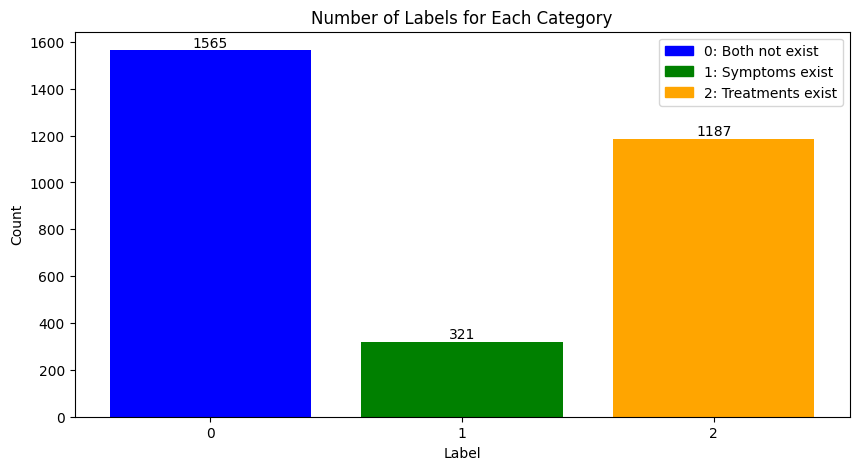

In [ ]:
# Define colors for each label
colors = ['blue', 'green', 'orange']

# Plot the label counts
plt.figure(figsize=(10, 5))
# Plotting the bar chart with different colors
bars = plt.bar(label_counts.index, label_counts.values, color=[colors[label] for label in label_counts.index])

# Add count annotations on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Number of Labels for Each Category')
plt.xticks(label_counts.index)

# Adding a legend with custom labels and sorted order
custom_labels = {0: '0: Both not exist', 1: '1: Symptoms exist', 2: '2: Treatments exist'}
legend_handles = [mpatches.Patch(color=colors[label], label=custom_labels[label]) for label in label_counts.index]
plt.legend(bars, handles=legend_handles)

plt.show()

# Prepare Train Test Dataset

In [ ]:
# 80:20
# X contains the features (sentences), and y contains the labels
X = balanced_data['sentences']
y = balanced_data['label']

# Split the dataset into training and testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 'test_size=0.2' specifies that 20% of the data will be used for testing
# 'random_state=42' ensures reproducibility of the split, as it sets the random seed

# Print the shapes of the resulting datasets
print("Training set shape (X_train):", X_train.shape)
print("Testing set shape (X_test):", X_test.shape)
print("Training set shape (y_train):", y_train.shape)
print("Testing set shape (y_test):", y_test.shape)

Training set shape (X_train): (2458,)
Testing set shape (X_test): (615,)
Training set shape (y_train): (2458,)
Testing set shape (y_test): (615,)


# Feature Extraction

- ngram_range of (1,5) is used to create TF-IDF matrix that include unigrams, which are single words, bigrams which are two-word combinations and up to 5-grams which are five words combinations.
- due to the keywords defined are up to five words

In [ ]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,5))
tfidf_vectorizer.fit(X_train)

#applying TF-IDF to the splitted dataset
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [ ]:
# Print shapes to verify the splits
print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train_tfidf shape: (2458, 115110)
X_test_tfidf shape: (615, 115110)
y_train shape: (2458,)
y_test shape: (615,)


# Model Building and Evaluation

## SVM Model

###Model 1

c=0.8

In [ ]:
# SVM Model - linear
# fit the training dataset on the classifier
svm_model = SVC(C=0.8, kernel='linear', degree=3, gamma='auto')

# Train the model
svm_model.fit(X_train_tfidf,y_train)

# Predictions
svm_y_train_pred = svm_model.predict(X_train_tfidf)
svm_y_test_pred = svm_model.predict(X_test_tfidf)

# Evaluate SVM Model - Use accuracy_score function to get the accuracy
svm_train_accuracy = accuracy_score(svm_y_train_pred, y_train)
svm_test_accuracy = accuracy_score(svm_y_test_pred, y_test)

print("\nSVM Model:")
print("Accuracy score for train dataset:", svm_train_accuracy)
print("Accuracy score for test dataset:", svm_test_accuracy)

# Percentage of accuracy
print("SVM Accuracy Score -> ", svm_test_accuracy*100, "%")


SVM Model:
Accuracy score for train dataset: 0.9967453213995118
Accuracy score for test dataset: 0.959349593495935
SVM Accuracy Score ->  95.9349593495935 %


In [ ]:
print(metrics.classification_report(y_test, svm_y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       326
           1       0.98      0.82      0.89        56
           2       0.96      0.98      0.97       233

    accuracy                           0.96       615
   macro avg       0.96      0.92      0.94       615
weighted avg       0.96      0.96      0.96       615



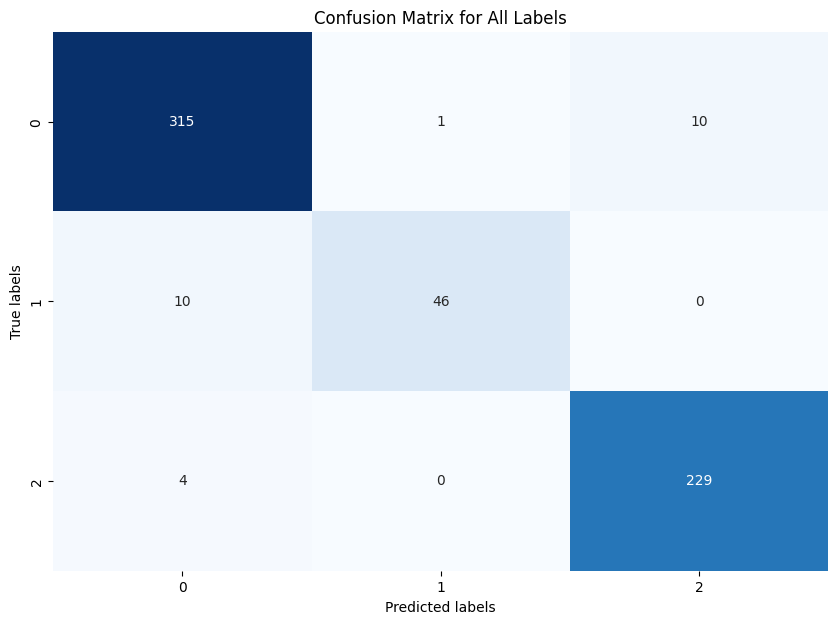

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, svm_y_test_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 2

c=0.9

In [ ]:
# SVM Model - linear
# fit the training dataset on the classifier
svm_model = SVC(C=0.9, kernel='linear', degree=3, gamma='auto')

# Train the model
svm_model.fit(X_train_tfidf,y_train)

# Predictions
svm_y_train_pred = svm_model.predict(X_train_tfidf)
svm_y_test_pred = svm_model.predict(X_test_tfidf)

# Evaluate SVM Model - Use accuracy_score function to get the accuracy
svm_train_accuracy = accuracy_score(svm_y_train_pred, y_train)
svm_test_accuracy = accuracy_score(svm_y_test_pred, y_test)

print("\nSVM Model:")
print("Accuracy score for train dataset:", svm_train_accuracy)
print("Accuracy score for test dataset:", svm_test_accuracy)

# Percentage of accuracy
print("SVM Accuracy Score -> ", svm_test_accuracy*100, "%")


SVM Model:
Accuracy score for train dataset: 0.999593165174939
Accuracy score for test dataset: 0.967479674796748
SVM Accuracy Score ->  96.7479674796748 %


In [ ]:
print(metrics.classification_report(y_test, svm_y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       326
           1       0.98      0.93      0.95        56
           2       0.95      0.98      0.97       233

    accuracy                           0.97       615
   macro avg       0.97      0.96      0.96       615
weighted avg       0.97      0.97      0.97       615



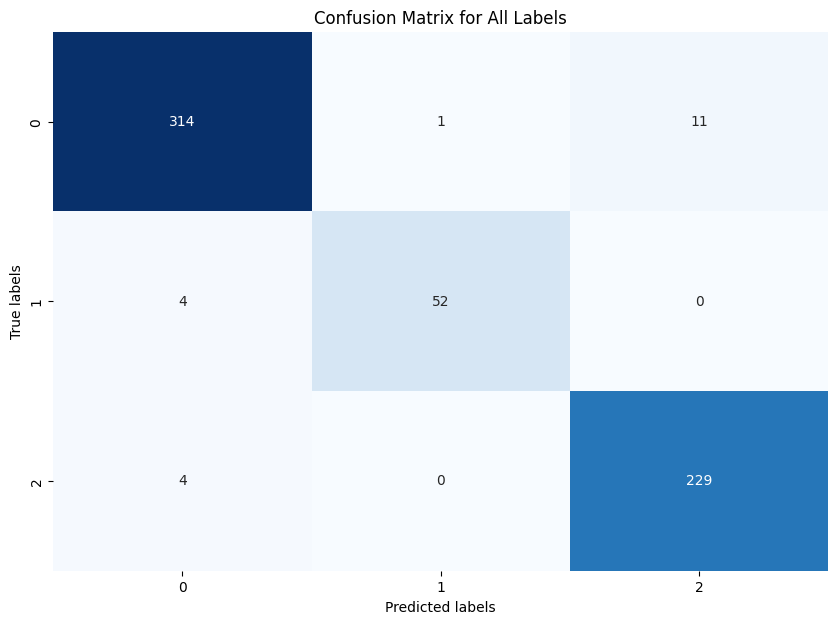

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, svm_y_test_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 3

C=1.0

In [ ]:
# SVM Model - linear
# fit the training dataset on the classifier
svm_model = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

# Train the model
svm_model.fit(X_train_tfidf,y_train)

# Predictions
svm_y_train_pred = svm_model.predict(X_train_tfidf)
svm_y_test_pred = svm_model.predict(X_test_tfidf)

# Evaluate SVM Model - Use accuracy_score function to get the accuracy
svm_train_accuracy = accuracy_score(svm_y_train_pred, y_train)
svm_test_accuracy = accuracy_score(svm_y_test_pred, y_test)

print("\nSVM Model:")
print("Accuracy score for train dataset:", svm_train_accuracy)
print("Accuracy score for test dataset:", svm_test_accuracy)

# Percentage of accuracy
print("SVM Accuracy Score -> ", svm_test_accuracy*100, "%")


SVM Model:
Accuracy score for train dataset: 1.0
Accuracy score for test dataset: 0.9642276422764228
SVM Accuracy Score ->  96.42276422764228 %


In [ ]:
print(metrics.classification_report(y_test, svm_y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       326
           1       0.96      0.93      0.95        56
           2       0.95      0.99      0.97       233

    accuracy                           0.96       615
   macro avg       0.96      0.96      0.96       615
weighted avg       0.96      0.96      0.96       615



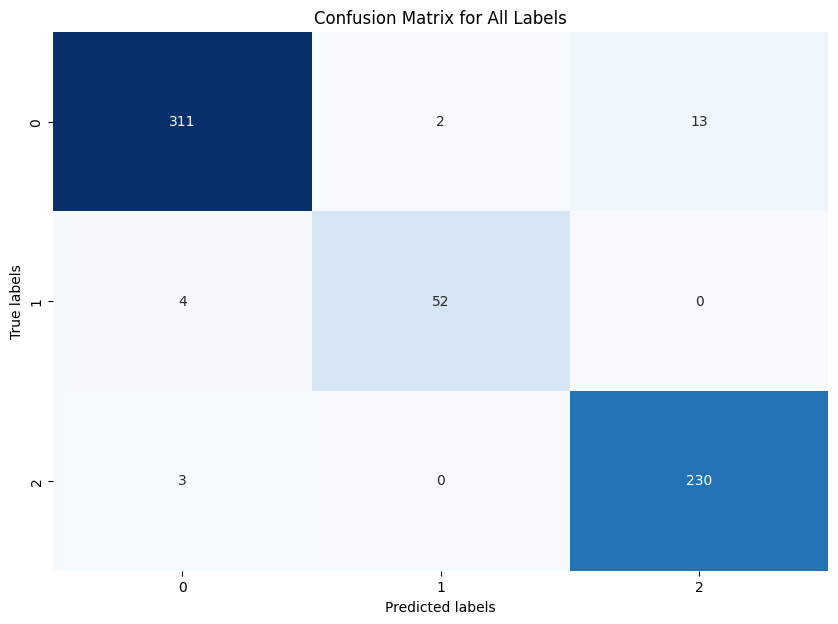

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, svm_y_test_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 4

c=1.1

In [ ]:
# SVM Model - linear
# fit the training dataset on the classifier
svm_model = SVC(C=1.1, kernel='linear', degree=3, gamma='auto')

# Train the model
svm_model.fit(X_train_tfidf,y_train)

# Predictions
svm_y_train_pred = svm_model.predict(X_train_tfidf)
svm_y_test_pred = svm_model.predict(X_test_tfidf)

# Evaluate SVM Model - Use accuracy_score function to get the accuracy
svm_train_accuracy = accuracy_score(svm_y_train_pred, y_train)
svm_test_accuracy = accuracy_score(svm_y_test_pred, y_test)

print("\nSVM Model:")
print("Accuracy score for train dataset:", svm_train_accuracy)
print("Accuracy score for test dataset:", svm_test_accuracy)

# Percentage of accuracy
print("SVM Accuracy Score -> ", svm_test_accuracy*100, "%")


SVM Model:
Accuracy score for train dataset: 1.0
Accuracy score for test dataset: 0.9626016260162602
SVM Accuracy Score ->  96.26016260162602 %


In [ ]:
print(metrics.classification_report(y_test, svm_y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       326
           1       0.96      0.95      0.95        56
           2       0.94      0.99      0.96       233

    accuracy                           0.96       615
   macro avg       0.96      0.96      0.96       615
weighted avg       0.96      0.96      0.96       615



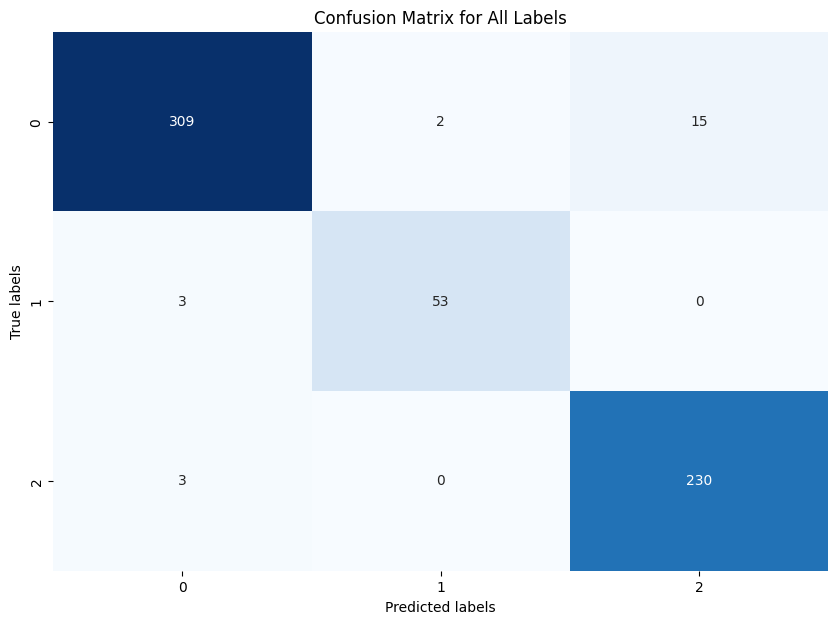

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, svm_y_test_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 5

c=1.2

In [ ]:
# SVM Model - linear
# fit the training dataset on the classifier
svm_model = SVC(C=1.2, kernel='linear', degree=3, gamma='auto')

# Train the model
svm_model.fit(X_train_tfidf,y_train)

# Predictions
svm_y_train_pred = svm_model.predict(X_train_tfidf)
svm_y_test_pred = svm_model.predict(X_test_tfidf)

# Evaluate SVM Model - Use accuracy_score function to get the accuracy
svm_train_accuracy = accuracy_score(svm_y_train_pred, y_train)
svm_test_accuracy = accuracy_score(svm_y_test_pred, y_test)

print("\nSVM Model:")
print("Accuracy score for train dataset:", svm_train_accuracy)
print("Accuracy score for test dataset:", svm_test_accuracy)

# Percentage of accuracy
print("SVM Accuracy Score -> ", svm_test_accuracy*100, "%")


SVM Model:
Accuracy score for train dataset: 1.0
Accuracy score for test dataset: 0.9609756097560975
SVM Accuracy Score ->  96.09756097560975 %


In [ ]:
print(metrics.classification_report(y_test, svm_y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       326
           1       0.95      0.95      0.95        56
           2       0.93      0.99      0.96       233

    accuracy                           0.96       615
   macro avg       0.96      0.96      0.96       615
weighted avg       0.96      0.96      0.96       615



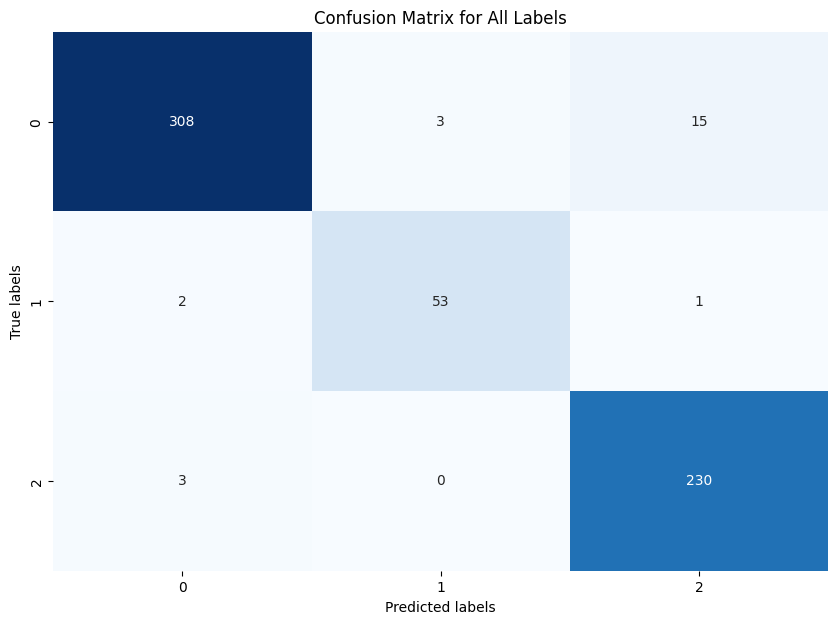

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, svm_y_test_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 6

c=1.3

In [ ]:
# SVM Model - linear
# fit the training dataset on the classifier
svm_model = SVC(C=1.3, kernel='linear', degree=3, gamma='auto')

# Train the model
svm_model.fit(X_train_tfidf,y_train)

# Predictions
svm_y_train_pred = svm_model.predict(X_train_tfidf)
svm_y_test_pred = svm_model.predict(X_test_tfidf)

# Evaluate SVM Model - Use accuracy_score function to get the accuracy
svm_train_accuracy = accuracy_score(svm_y_train_pred, y_train)
svm_test_accuracy = accuracy_score(svm_y_test_pred, y_test)

print("\nSVM Model:")
print("Accuracy score for train dataset:", svm_train_accuracy)
print("Accuracy score for test dataset:", svm_test_accuracy)

# Percentage of accuracy
print("SVM Accuracy Score -> ", svm_test_accuracy*100, "%")


SVM Model:
Accuracy score for train dataset: 1.0
Accuracy score for test dataset: 0.9609756097560975
SVM Accuracy Score ->  96.09756097560975 %


In [ ]:
print(metrics.classification_report(y_test, svm_y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       326
           1       0.95      0.95      0.95        56
           2       0.93      0.99      0.96       233

    accuracy                           0.96       615
   macro avg       0.96      0.96      0.96       615
weighted avg       0.96      0.96      0.96       615



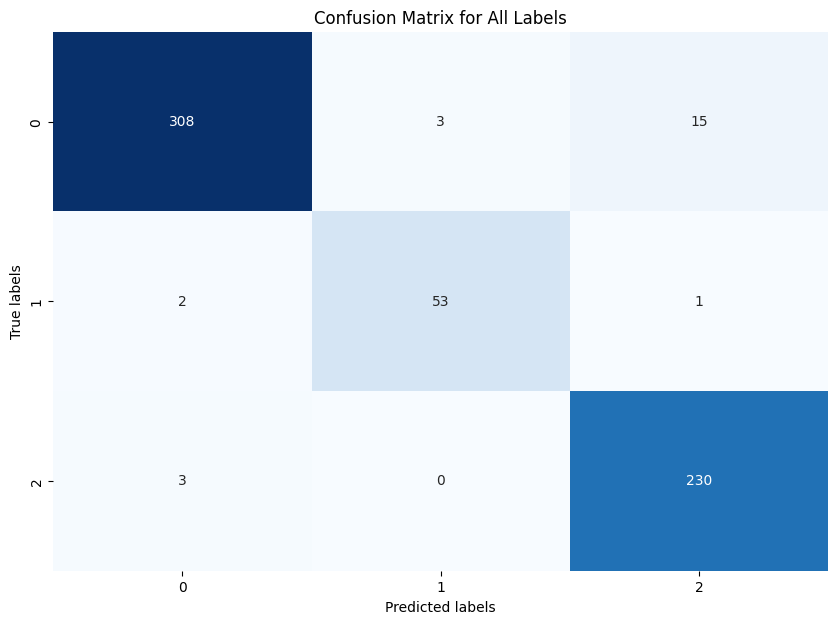

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, svm_y_test_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

## Decision Tree Model

###Model 1

max_depth=21, max_features=10000

In [ ]:
from sklearn import metrics

# Number of runs
n_runs = 10

# Store the accuracies
train_accuracies = []
test_accuracies = []

# Store the classification reports and confusion matrices
classification_reports = []
confusion_matrices = []

# Loop for 10 runs
for i in range(n_runs):
    # Initialize the Decision Tree model
    dt_model = DecisionTreeClassifier(max_depth=21, max_features=10000)

    # Train the model
    dt_model.fit(X_train_tfidf, y_train)

    # Predictions
    dt_y_train_pred = dt_model.predict(X_train_tfidf)
    dt_y_test_pred = dt_model.predict(X_test_tfidf)

    # Evaluate the model
    dt_train_accuracy = accuracy_score(y_train, dt_y_train_pred)
    dt_test_accuracy = accuracy_score(y_test, dt_y_test_pred)
    print("\nTrain Accuracy", i, ": ", dt_train_accuracy)
    print("Test Accuracy", i, ": ", dt_test_accuracy)

    # Store the accuracies
    train_accuracies.append(dt_train_accuracy)
    test_accuracies.append(dt_test_accuracy)

    # Generate and store classification report
    report = metrics.classification_report(y_test, dt_y_test_pred, output_dict=True)
    classification_reports.append(report)

    # Generate and store confusion matrix
    cm = confusion_matrix(y_test, dt_y_test_pred)
    confusion_matrices.append(cm)

# Calculate the average accuracies
average_train_accuracy = np.mean(train_accuracies)
average_test_accuracy = np.mean(test_accuracies)

print("\nDecision Tree Model (10 runs):")
print("Average Train Accuracy:", average_train_accuracy)
print("Average Test Accuracy:", average_test_accuracy)

# Percentage of accuracy
print("Average Decision Tree Test Accuracy Score -> ", average_test_accuracy * 100, "%")



Train Accuracy 0 :  0.935720097640358
Test Accuracy 0 :  0.9382113821138212

Train Accuracy 1 :  0.9227013832384052
Test Accuracy 1 :  0.8991869918699187

Train Accuracy 2 :  0.9918633034987795
Test Accuracy 2 :  0.9804878048780488

Train Accuracy 3 :  0.9707078925956062
Test Accuracy 3 :  0.9723577235772358

Train Accuracy 4 :  0.9625711960943857
Test Accuracy 4 :  0.9658536585365853

Train Accuracy 5 :  0.9922701383238405
Test Accuracy 5 :  0.9691056910569106

Train Accuracy 6 :  0.9719283970707893
Test Accuracy 6 :  0.9642276422764228

Train Accuracy 7 :  0.9450772986167616
Test Accuracy 7 :  0.943089430894309

Train Accuracy 8 :  0.9731489015459723
Test Accuracy 8 :  0.9739837398373984

Train Accuracy 9 :  0.9934906427990235
Test Accuracy 9 :  0.991869918699187

Decision Tree Model (10 runs):
Average Train Accuracy: 0.9659479251423922
Average Test Accuracy: 0.9598373983739839
Average Decision Tree Test Accuracy Score ->  95.98373983739839 %


In [ ]:
# Average the classification reports
average_report = {}

# Identify keys that contain detailed metrics
metric_keys = [key for key in classification_reports[0].keys() if isinstance(classification_reports[0][key], dict)]

# Initialize average report structure
for key in metric_keys:
    average_report[key] = {}
    for metric in classification_reports[0][key].keys():
        average_report[key][metric] = np.mean([report[key][metric] for report in classification_reports])

# Handle the 'accuracy' key separately if it exists
if 'accuracy' in classification_reports[0]:
    average_report['accuracy'] = np.mean([report['accuracy'] for report in classification_reports])

# Print the average classification report
print("\nAverage Classification Report:")
for label, metrics in average_report.items():
    if isinstance(metrics, dict):  # Detailed metrics
        print(f"Class: {label}")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.2f}")
    else:  # Overall accuracy
        print(f"{label}: {metrics:.2f}")


Average Classification Report:
Class: 0
  precision: 0.94
  recall: 0.99
  f1-score: 0.96
  support: 326.00
Class: 1
  precision: 0.94
  recall: 0.84
  f1-score: 0.88
  support: 56.00
Class: 2
  precision: 0.99
  recall: 0.95
  f1-score: 0.97
  support: 233.00
Class: macro avg
  precision: 0.96
  recall: 0.93
  f1-score: 0.94
  support: 615.00
Class: weighted avg
  precision: 0.96
  recall: 0.96
  f1-score: 0.96
  support: 615.00
accuracy: 0.96


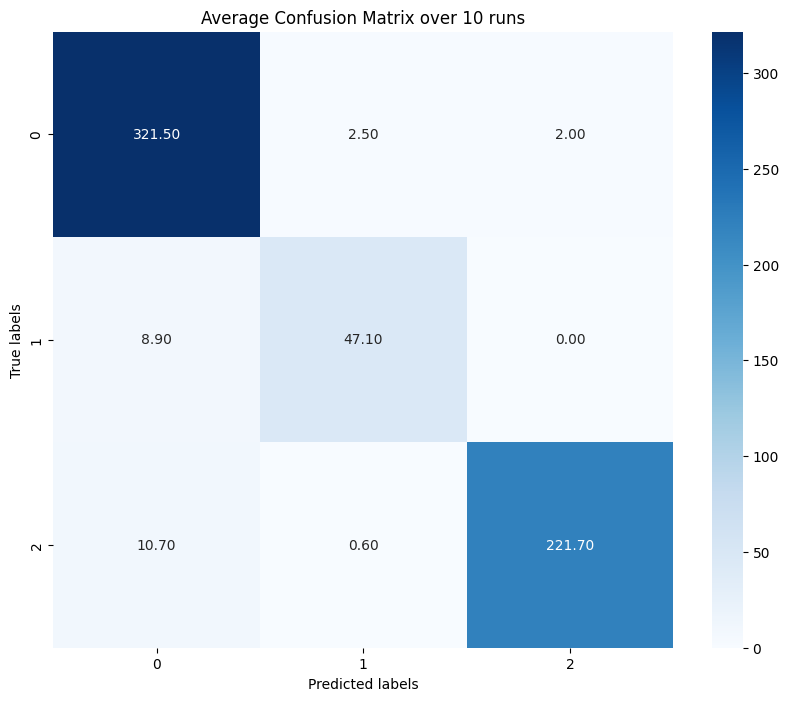

In [ ]:
# Calculate the average confusion matrix
average_cm = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(average_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Average Confusion Matrix over 10 runs')
plt.show()

###Model 2

max_depth=22, max_features=10000

In [ ]:
from sklearn import metrics

# Number of runs
n_runs = 10

# Store the accuracies
train_accuracies = []
test_accuracies = []

# Store the classification reports and confusion matrices
classification_reports = []
confusion_matrices = []

# Loop for 10 runs
for i in range(n_runs):
    # Initialize the Decision Tree model
    dt_model = DecisionTreeClassifier(max_depth=22, max_features=10000)

    # Train the model
    dt_model.fit(X_train_tfidf, y_train)

    # Predictions
    dt_y_train_pred = dt_model.predict(X_train_tfidf)
    dt_y_test_pred = dt_model.predict(X_test_tfidf)

    # Evaluate the model
    dt_train_accuracy = accuracy_score(y_train, dt_y_train_pred)
    dt_test_accuracy = accuracy_score(y_test, dt_y_test_pred)
    print("\nTrain Accuracy", i, ": ", dt_train_accuracy)
    print("Test Accuracy", i, ": ", dt_test_accuracy)

    # Store the accuracies
    train_accuracies.append(dt_train_accuracy)
    test_accuracies.append(dt_test_accuracy)

    # Generate and store classification report
    report = metrics.classification_report(y_test, dt_y_test_pred, output_dict=True)
    classification_reports.append(report)

    # Generate and store confusion matrix
    cm = confusion_matrix(y_test, dt_y_test_pred)
    confusion_matrices.append(cm)

# Calculate the average accuracies
average_train_accuracy = np.mean(train_accuracies)
average_test_accuracy = np.mean(test_accuracies)

print("\nDecision Tree Model (10 runs):")
print("Average Train Accuracy:", average_train_accuracy)
print("Average Test Accuracy:", average_test_accuracy)

# Percentage of accuracy
print("Average Decision Tree Test Accuracy Score -> ", average_test_accuracy * 100, "%")



Train Accuracy 0 :  0.934499593165175
Test Accuracy 0 :  0.9317073170731708

Train Accuracy 1 :  0.9938974776240846
Test Accuracy 1 :  0.9902439024390244

Train Accuracy 2 :  0.9812855980471928
Test Accuracy 2 :  0.9691056910569106

Train Accuracy 3 :  0.9776240846216436
Test Accuracy 3 :  0.9772357723577236

Train Accuracy 4 :  0.9694873881204231
Test Accuracy 4 :  0.9691056910569106

Train Accuracy 5 :  0.9922701383238405
Test Accuracy 5 :  0.9886178861788618

Train Accuracy 6 :  0.9865744507729862
Test Accuracy 6 :  0.9739837398373984

Train Accuracy 7 :  0.8543531326281529
Test Accuracy 7 :  0.8422764227642277

Train Accuracy 8 :  0.9959316517493898
Test Accuracy 8 :  0.9886178861788618

Train Accuracy 9 :  0.9739625711960944
Test Accuracy 9 :  0.9560975609756097

Decision Tree Model (10 runs):
Average Train Accuracy: 0.9659886086248983
Average Test Accuracy: 0.9586991869918698
Average Decision Tree Test Accuracy Score ->  95.86991869918698 %


In [ ]:
# Average the classification reports
average_report = {}

# Identify keys that contain detailed metrics
metric_keys = [key for key in classification_reports[0].keys() if isinstance(classification_reports[0][key], dict)]

# Initialize average report structure
for key in metric_keys:
    average_report[key] = {}
    for metric in classification_reports[0][key].keys():
        average_report[key][metric] = np.mean([report[key][metric] for report in classification_reports])

# Handle the 'accuracy' key separately if it exists
if 'accuracy' in classification_reports[0]:
    average_report['accuracy'] = np.mean([report['accuracy'] for report in classification_reports])

# Print the average classification report
print("\nAverage Classification Report:")
for label, metrics in average_report.items():
    if isinstance(metrics, dict):  # Detailed metrics
        print(f"Class: {label}")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.2f}")
    else:  # Overall accuracy
        print(f"{label}: {metrics:.2f}")


Average Classification Report:
Class: 0
  precision: 0.94
  recall: 0.99
  f1-score: 0.96
  support: 326.00
Class: 1
  precision: 0.94
  recall: 0.88
  f1-score: 0.91
  support: 56.00
Class: 2
  precision: 0.99
  recall: 0.94
  f1-score: 0.96
  support: 233.00
Class: macro avg
  precision: 0.96
  recall: 0.94
  f1-score: 0.94
  support: 615.00
Class: weighted avg
  precision: 0.96
  recall: 0.96
  f1-score: 0.96
  support: 615.00
accuracy: 0.96


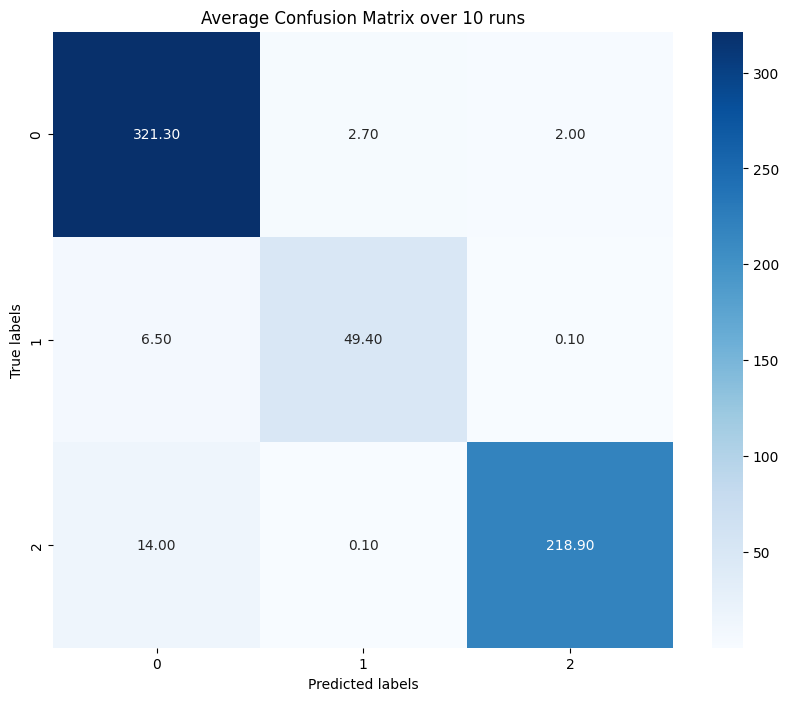

In [ ]:
# Calculate the average confusion matrix
average_cm = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(average_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Average Confusion Matrix over 10 runs')
plt.show()

###Model 3

max_depth=23, max_features=10000

In [ ]:
from sklearn import metrics

# Number of runs
n_runs = 10

# Store the accuracies
train_accuracies = []
test_accuracies = []

# Store the classification reports and confusion matrices
classification_reports = []
confusion_matrices = []

# Loop for 10 runs
for i in range(n_runs):
    # Initialize the Decision Tree model
    dt_model = DecisionTreeClassifier(max_depth=23, max_features=10000)

    # Train the model
    dt_model.fit(X_train_tfidf, y_train)

    # Predictions
    dt_y_train_pred = dt_model.predict(X_train_tfidf)
    dt_y_test_pred = dt_model.predict(X_test_tfidf)

    # Evaluate the model
    dt_train_accuracy = accuracy_score(y_train, dt_y_train_pred)
    dt_test_accuracy = accuracy_score(y_test, dt_y_test_pred)
    print("\nTrain Accuracy", i, ": ", dt_train_accuracy)
    print("Test Accuracy", i, ": ", dt_test_accuracy)

    # Store the accuracies
    train_accuracies.append(dt_train_accuracy)
    test_accuracies.append(dt_test_accuracy)

    # Generate and store classification report
    report = metrics.classification_report(y_test, dt_y_test_pred, output_dict=True)
    classification_reports.append(report)

    # Generate and store confusion matrix
    cm = confusion_matrix(y_test, dt_y_test_pred)
    confusion_matrices.append(cm)

# Calculate the average accuracies
average_train_accuracy = np.mean(train_accuracies)
average_test_accuracy = np.mean(test_accuracies)

print("\nDecision Tree Model (10 runs):")
print("Average Train Accuracy:", average_train_accuracy)
print("Average Test Accuracy:", average_test_accuracy)

# Percentage of accuracy
print("Average Decision Tree Test Accuracy Score -> ", average_test_accuracy * 100, "%")



Train Accuracy 0 :  0.8409275834011392
Test Accuracy 0 :  0.8276422764227642

Train Accuracy 1 :  0.869812855980472
Test Accuracy 1 :  0.8617886178861789

Train Accuracy 2 :  0.9869812855980472
Test Accuracy 2 :  0.975609756097561

Train Accuracy 3 :  0.9613506916192026
Test Accuracy 3 :  0.9609756097560975

Train Accuracy 4 :  0.9690805532953621
Test Accuracy 4 :  0.9788617886178862

Train Accuracy 5 :  0.968673718470301
Test Accuracy 5 :  0.9707317073170731

Train Accuracy 6 :  0.9239218877135883
Test Accuracy 6 :  0.9008130081300812

Train Accuracy 7 :  0.9796582587469488
Test Accuracy 7 :  0.9772357723577236

Train Accuracy 8 :  0.9723352318958502
Test Accuracy 8 :  0.9723577235772358

Train Accuracy 9 :  0.9979658258746948
Test Accuracy 9 :  0.9934959349593496

Decision Tree Model (10 runs):
Average Train Accuracy: 0.9470707892595607
Average Test Accuracy: 0.9419512195121952
Average Decision Tree Test Accuracy Score ->  94.19512195121952 %


In [ ]:
# Average the classification reports
average_report = {}

# Identify keys that contain detailed metrics
metric_keys = [key for key in classification_reports[0].keys() if isinstance(classification_reports[0][key], dict)]

# Initialize average report structure
for key in metric_keys:
    average_report[key] = {}
    for metric in classification_reports[0][key].keys():
        average_report[key][metric] = np.mean([report[key][metric] for report in classification_reports])

# Handle the 'accuracy' key separately if it exists
if 'accuracy' in classification_reports[0]:
    average_report['accuracy'] = np.mean([report['accuracy'] for report in classification_reports])

# Print the average classification report
print("\nAverage Classification Report:")
for label, metrics in average_report.items():
    if isinstance(metrics, dict):  # Detailed metrics
        print(f"Class: {label}")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.2f}")
    else:  # Overall accuracy
        print(f"{label}: {metrics:.2f}")


Average Classification Report:
Class: 0
  precision: 0.92
  recall: 0.98
  f1-score: 0.95
  support: 326.00
Class: 1
  precision: 0.95
  recall: 0.83
  f1-score: 0.88
  support: 56.00
Class: 2
  precision: 0.98
  recall: 0.91
  f1-score: 0.94
  support: 233.00
Class: macro avg
  precision: 0.95
  recall: 0.91
  f1-score: 0.92
  support: 615.00
Class: weighted avg
  precision: 0.95
  recall: 0.94
  f1-score: 0.94
  support: 615.00
accuracy: 0.94


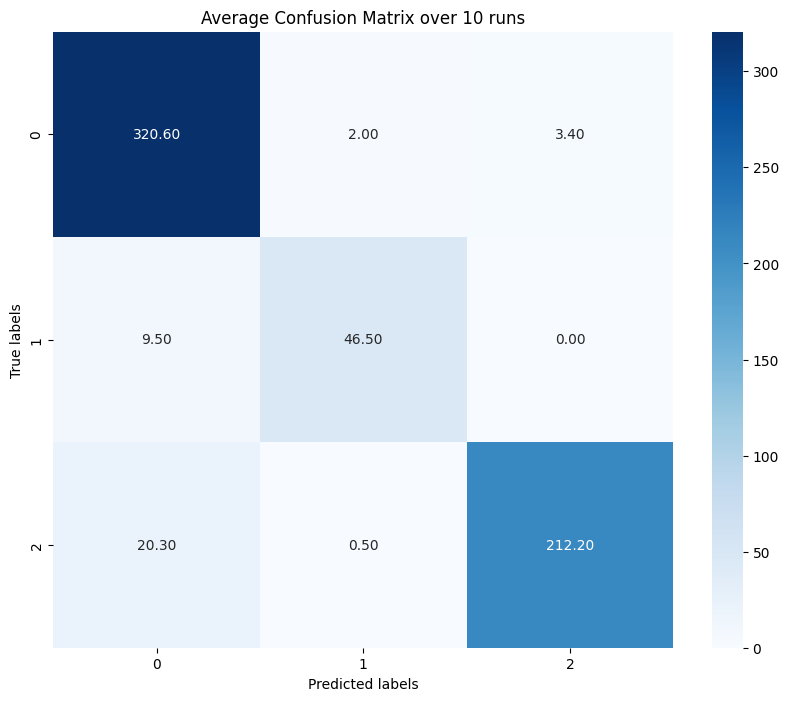

In [ ]:
# Calculate the average confusion matrix
average_cm = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(average_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Average Confusion Matrix over 10 runs')
plt.show()

###Model 4

max_depth=24, max_features=10000

In [ ]:
from sklearn import metrics

# Number of runs
n_runs = 10

# Store the accuracies
train_accuracies = []
test_accuracies = []

# Store the classification reports and confusion matrices
classification_reports = []
confusion_matrices = []

# Loop for 10 runs
for i in range(n_runs):
    # Initialize the Decision Tree model
    dt_model = DecisionTreeClassifier(max_depth=24, max_features=10000)

    # Train the model
    dt_model.fit(X_train_tfidf, y_train)

    # Predictions
    dt_y_train_pred = dt_model.predict(X_train_tfidf)
    dt_y_test_pred = dt_model.predict(X_test_tfidf)

    # Evaluate the model
    dt_train_accuracy = accuracy_score(y_train, dt_y_train_pred)
    dt_test_accuracy = accuracy_score(y_test, dt_y_test_pred)
    print("\nTrain Accuracy", i, ": ", dt_train_accuracy)
    print("Test Accuracy", i, ": ", dt_test_accuracy)

    # Store the accuracies
    train_accuracies.append(dt_train_accuracy)
    test_accuracies.append(dt_test_accuracy)

    # Generate and store classification report
    report = metrics.classification_report(y_test, dt_y_test_pred, output_dict=True)
    classification_reports.append(report)

    # Generate and store confusion matrix
    cm = confusion_matrix(y_test, dt_y_test_pred)
    confusion_matrices.append(cm)

# Calculate the average accuracies
average_train_accuracy = np.mean(train_accuracies)
average_test_accuracy = np.mean(test_accuracies)

print("\nDecision Tree Model (10 runs):")
print("Average Train Accuracy:", average_train_accuracy)
print("Average Test Accuracy:", average_test_accuracy)

# Percentage of accuracy
print("Average Decision Tree Test Accuracy Score -> ", average_test_accuracy * 100, "%")



Train Accuracy 0 :  0.9743694060211554
Test Accuracy 0 :  0.9609756097560975

Train Accuracy 1 :  0.9918633034987795
Test Accuracy 1 :  0.9886178861788618

Train Accuracy 2 :  0.9735557363710333
Test Accuracy 2 :  0.9772357723577236

Train Accuracy 3 :  0.9975589910496339
Test Accuracy 3 :  0.9739837398373984

Train Accuracy 4 :  0.9914564686737185
Test Accuracy 4 :  0.975609756097561

Train Accuracy 5 :  0.950772986167616
Test Accuracy 5 :  0.9642276422764228

Train Accuracy 6 :  0.9894222945484134
Test Accuracy 6 :  0.9821138211382113

Train Accuracy 7 :  0.8685923515052889
Test Accuracy 7 :  0.8439024390243902

Train Accuracy 8 :  0.9698942229454841
Test Accuracy 8 :  0.9658536585365853

Train Accuracy 9 :  0.9845402766476811
Test Accuracy 9 :  0.9821138211382113

Decision Tree Model (10 runs):
Average Train Accuracy: 0.9692026037428805
Average Test Accuracy: 0.9614634146341464
Average Decision Tree Test Accuracy Score ->  96.14634146341464 %


In [ ]:
# Average the classification reports
average_report = {}

# Identify keys that contain detailed metrics
metric_keys = [key for key in classification_reports[0].keys() if isinstance(classification_reports[0][key], dict)]

# Initialize average report structure
for key in metric_keys:
    average_report[key] = {}
    for metric in classification_reports[0][key].keys():
        average_report[key][metric] = np.mean([report[key][metric] for report in classification_reports])

# Handle the 'accuracy' key separately if it exists
if 'accuracy' in classification_reports[0]:
    average_report['accuracy'] = np.mean([report['accuracy'] for report in classification_reports])

# Print the average classification report
print("\nAverage Classification Report:")
for label, metrics in average_report.items():
    if isinstance(metrics, dict):  # Detailed metrics
        print(f"Class: {label}")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.2f}")
    else:  # Overall accuracy
        print(f"{label}: {metrics:.2f}")


Average Classification Report:
Class: 0
  precision: 0.95
  recall: 0.98
  f1-score: 0.97
  support: 326.00
Class: 1
  precision: 0.94
  recall: 0.88
  f1-score: 0.91
  support: 56.00
Class: 2
  precision: 0.99
  recall: 0.95
  f1-score: 0.97
  support: 233.00
Class: macro avg
  precision: 0.96
  recall: 0.94
  f1-score: 0.95
  support: 615.00
Class: weighted avg
  precision: 0.96
  recall: 0.96
  f1-score: 0.96
  support: 615.00
accuracy: 0.96


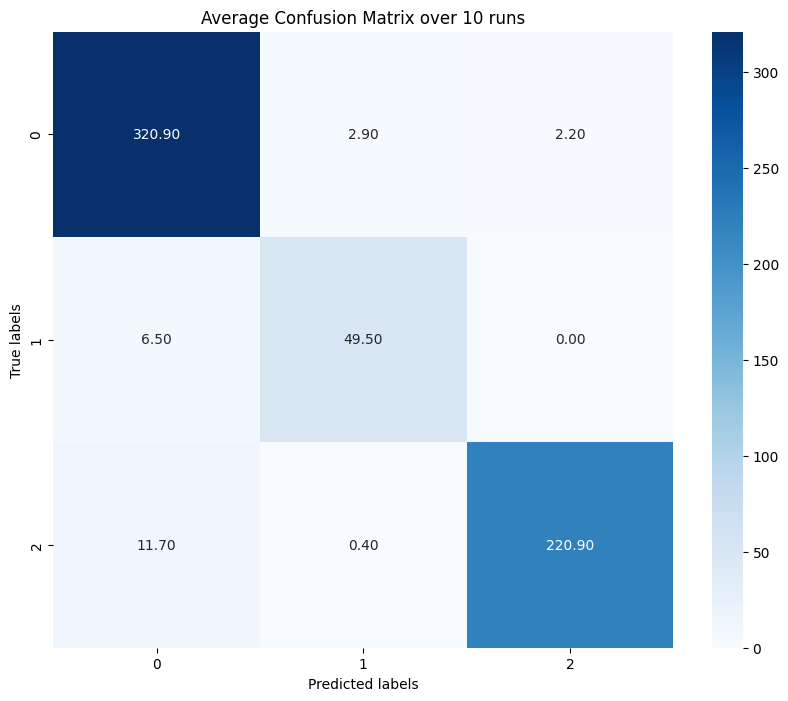

In [ ]:
# Calculate the average confusion matrix
average_cm = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(average_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Average Confusion Matrix over 10 runs')
plt.show()

###Model 5

max_depth=25, max_features=10000

In [ ]:
from sklearn import metrics

# Number of runs
n_runs = 10

# Store the accuracies
train_accuracies = []
test_accuracies = []

# Store the classification reports and confusion matrices
classification_reports = []
confusion_matrices = []

# Loop for 10 runs
for i in range(n_runs):
    # Initialize the Decision Tree model
    dt_model = DecisionTreeClassifier(max_depth=25, max_features=10000)

    # Train the model
    dt_model.fit(X_train_tfidf, y_train)

    # Predictions
    dt_y_train_pred = dt_model.predict(X_train_tfidf)
    dt_y_test_pred = dt_model.predict(X_test_tfidf)

    # Evaluate the model
    dt_train_accuracy = accuracy_score(y_train, dt_y_train_pred)
    dt_test_accuracy = accuracy_score(y_test, dt_y_test_pred)
    print("\nTrain Accuracy", i, ": ", dt_train_accuracy)
    print("Test Accuracy", i, ": ", dt_test_accuracy)

    # Store the accuracies
    train_accuracies.append(dt_train_accuracy)
    test_accuracies.append(dt_test_accuracy)

    # Generate and store classification report
    report = metrics.classification_report(y_test, dt_y_test_pred, output_dict=True)
    classification_reports.append(report)

    # Generate and store confusion matrix
    cm = confusion_matrix(y_test, dt_y_test_pred)
    confusion_matrices.append(cm)

# Calculate the average accuracies
average_train_accuracy = np.mean(train_accuracies)
average_test_accuracy = np.mean(test_accuracies)

print("\nDecision Tree Model (10 runs):")
print("Average Train Accuracy:", average_train_accuracy)
print("Average Test Accuracy:", average_test_accuracy)

# Percentage of accuracy
print("Average Decision Tree Test Accuracy Score -> ", average_test_accuracy * 100, "%")



Train Accuracy 0 :  0.9914564686737185
Test Accuracy 0 :  0.9723577235772358

Train Accuracy 1 :  0.9890154597233524
Test Accuracy 1 :  0.967479674796748

Train Accuracy 2 :  0.9613506916192026
Test Accuracy 2 :  0.9577235772357724

Train Accuracy 3 :  0.9951179820992677
Test Accuracy 3 :  0.9804878048780488

Train Accuracy 4 :  0.9861676159479251
Test Accuracy 4 :  0.9609756097560975

Train Accuracy 5 :  0.9873881204231082
Test Accuracy 5 :  0.9479674796747968

Train Accuracy 6 :  0.9877949552481693
Test Accuracy 6 :  0.983739837398374

Train Accuracy 7 :  0.9877949552481693
Test Accuracy 7 :  0.9804878048780488

Train Accuracy 8 :  0.967860048820179
Test Accuracy 8 :  0.967479674796748

Train Accuracy 9 :  0.9934906427990235
Test Accuracy 9 :  0.9821138211382113

Decision Tree Model (10 runs):
Average Train Accuracy: 0.9847436940602116
Average Test Accuracy: 0.9700813008130081
Average Decision Tree Test Accuracy Score ->  97.00813008130082 %


In [ ]:
# Average the classification reports
average_report = {}

# Identify keys that contain detailed metrics
metric_keys = [key for key in classification_reports[0].keys() if isinstance(classification_reports[0][key], dict)]

# Initialize average report structure
for key in metric_keys:
    average_report[key] = {}
    for metric in classification_reports[0][key].keys():
        average_report[key][metric] = np.mean([report[key][metric] for report in classification_reports])

# Handle the 'accuracy' key separately if it exists
if 'accuracy' in classification_reports[0]:
    average_report['accuracy'] = np.mean([report['accuracy'] for report in classification_reports])

# Print the average classification report
print("\nAverage Classification Report:")
for label, metrics in average_report.items():
    if isinstance(metrics, dict):  # Detailed metrics
        print(f"Class: {label}")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.2f}")
    else:  # Overall accuracy
        print(f"{label}: {metrics:.2f}")


Average Classification Report:
Class: 0
  precision: 0.97
  recall: 0.98
  f1-score: 0.97
  support: 326.00
Class: 1
  precision: 0.94
  recall: 0.93
  f1-score: 0.94
  support: 56.00
Class: 2
  precision: 0.98
  recall: 0.97
  f1-score: 0.97
  support: 233.00
Class: macro avg
  precision: 0.96
  recall: 0.96
  f1-score: 0.96
  support: 615.00
Class: weighted avg
  precision: 0.97
  recall: 0.97
  f1-score: 0.97
  support: 615.00
accuracy: 0.97


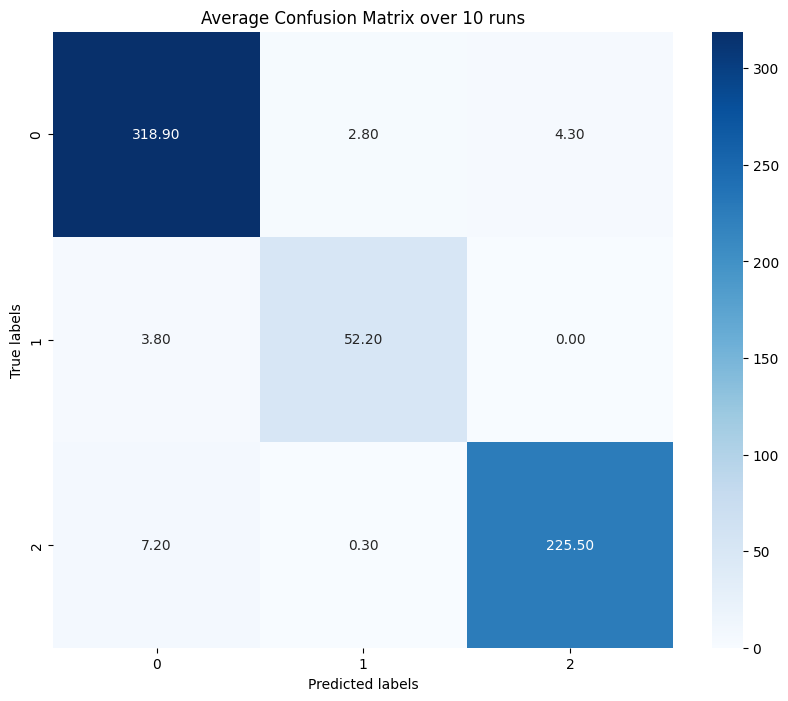

In [ ]:
# Calculate the average confusion matrix
average_cm = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(average_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Average Confusion Matrix over 10 runs')
plt.show()

## KNN Model

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

###Model 1

n=16

In [ ]:
# KNN Model
# fit the training dataset on the classifier
knn_model = KNeighborsClassifier(n_neighbors=16)

# Train the model
knn_model.fit(X_train_tfidf, y_train)

# Predictions
knn_y_train_pred = knn_model.predict(X_train_tfidf)
knn_y_test_pred = knn_model.predict(X_test_tfidf)

# Evaluate KNN model - Use accuracy_score function to get the accuracy
knn_train_accuracy = accuracy_score(y_train, knn_y_train_pred)
knn_test_accuracy = accuracy_score(y_test, knn_y_test_pred)

print("KNN Model:")
print("Train Accuracy:", knn_train_accuracy)
print("Test Accuracy:", knn_test_accuracy)

# Percentage of accuracy
print("KNN Accuracy Score -> ", knn_test_accuracy*100, "%")

KNN Model:
Train Accuracy: 0.8104149715215623
Test Accuracy: 0.7821138211382114
KNN Accuracy Score ->  78.21138211382113 %


In [ ]:
print(metrics.classification_report(y_test, knn_y_test_pred))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82       326
           1       0.83      0.52      0.64        56
           2       0.83      0.68      0.75       233

    accuracy                           0.78       615
   macro avg       0.80      0.70      0.74       615
weighted avg       0.79      0.78      0.78       615



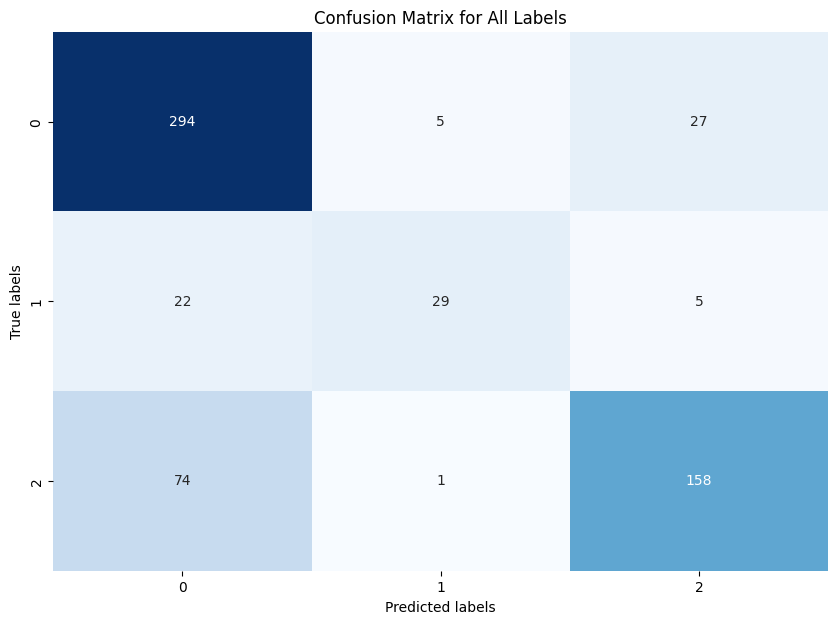

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, knn_y_test_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 2

n=17

In [ ]:
# KNN Model
# fit the training dataset on the classifier
knn_model = KNeighborsClassifier(n_neighbors=17)

# Train the model
knn_model.fit(X_train_tfidf, y_train)

# Predictions
knn_y_train_pred = knn_model.predict(X_train_tfidf)
knn_y_test_pred = knn_model.predict(X_test_tfidf)

# Evaluate KNN model - Use accuracy_score function to get the accuracy
knn_train_accuracy = accuracy_score(y_train, knn_y_train_pred)
knn_test_accuracy = accuracy_score(y_test, knn_y_test_pred)

print("KNN Model:")
print("Train Accuracy:", knn_train_accuracy)
print("Test Accuracy:", knn_test_accuracy)

# Percentage of accuracy
print("KNN Accuracy Score -> ", knn_test_accuracy*100, "%")

KNN Model:
Train Accuracy: 0.8120423108218063
Test Accuracy: 0.7902439024390244
KNN Accuracy Score ->  79.02439024390245 %


In [ ]:
print(metrics.classification_report(y_test, knn_y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.90      0.83       326
           1       0.85      0.50      0.63        56
           2       0.83      0.71      0.77       233

    accuracy                           0.79       615
   macro avg       0.81      0.70      0.74       615
weighted avg       0.80      0.79      0.78       615



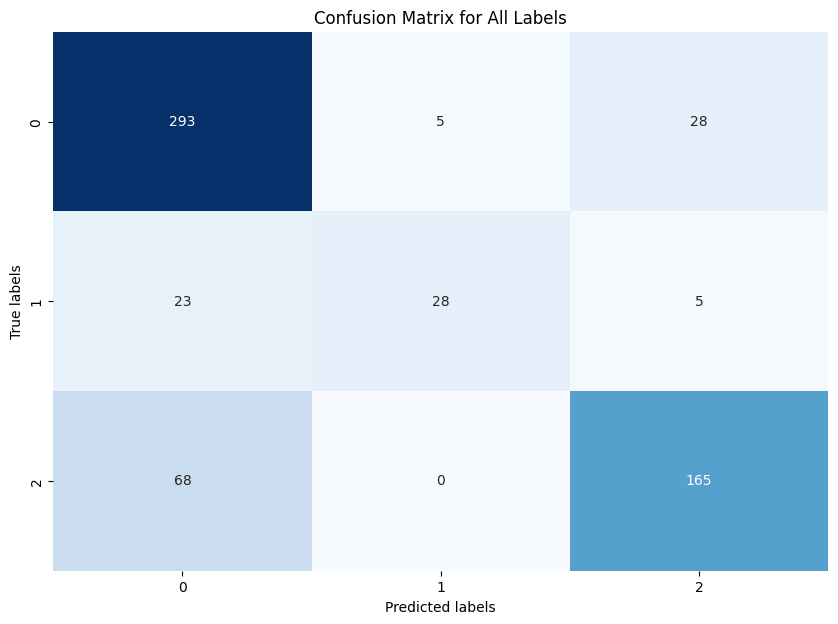

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, knn_y_test_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 3

n=18

In [ ]:
# KNN Model
# fit the training dataset on the classifier
knn_model = KNeighborsClassifier(n_neighbors=18)

# Train the model
knn_model.fit(X_train_tfidf, y_train)

# Predictions
knn_y_train_pred = knn_model.predict(X_train_tfidf)
knn_y_test_pred = knn_model.predict(X_test_tfidf)

# Evaluate KNN model - Use accuracy_score function to get the accuracy
knn_train_accuracy = accuracy_score(y_train, knn_y_train_pred)
knn_test_accuracy = accuracy_score(y_test, knn_y_test_pred)

print("KNN Model:")
print("Train Accuracy:", knn_train_accuracy)
print("Test Accuracy:", knn_test_accuracy)

# Percentage of accuracy
print("KNN Accuracy Score -> ", knn_test_accuracy*100, "%")

KNN Model:
Train Accuracy: 0.8083807973962571
Test Accuracy: 0.791869918699187
KNN Accuracy Score ->  79.1869918699187 %


In [ ]:
print(metrics.classification_report(y_test, knn_y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.90      0.83       326
           1       0.87      0.48      0.62        56
           2       0.83      0.71      0.77       233

    accuracy                           0.79       615
   macro avg       0.82      0.70      0.74       615
weighted avg       0.80      0.79      0.79       615



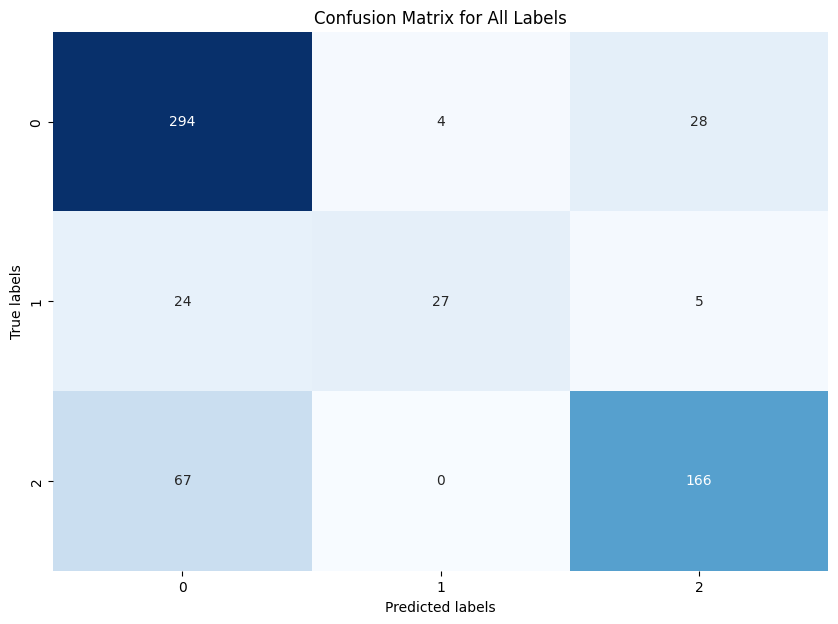

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, knn_y_test_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 4

n=19

In [ ]:
# KNN Model
# fit the training dataset on the classifier
knn_model = KNeighborsClassifier(n_neighbors=19)

# Train the model
knn_model.fit(X_train_tfidf, y_train)

# Predictions
knn_y_train_pred = knn_model.predict(X_train_tfidf)
knn_y_test_pred = knn_model.predict(X_test_tfidf)

# Evaluate KNN model - Use accuracy_score function to get the accuracy
knn_train_accuracy = accuracy_score(y_train, knn_y_train_pred)
knn_test_accuracy = accuracy_score(y_test, knn_y_test_pred)

print("KNN Model:")
print("Train Accuracy:", knn_train_accuracy)
print("Test Accuracy:", knn_test_accuracy)

# Percentage of accuracy
print("KNN Accuracy Score -> ", knn_test_accuracy*100, "%")

KNN Model:
Train Accuracy: 0.807160292921074
Test Accuracy: 0.8016260162601626
KNN Accuracy Score ->  80.16260162601625 %


In [ ]:
print(metrics.classification_report(y_test, knn_y_test_pred))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       326
           1       0.88      0.50      0.64        56
           2       0.84      0.73      0.78       233

    accuracy                           0.80       615
   macro avg       0.83      0.71      0.75       615
weighted avg       0.81      0.80      0.80       615



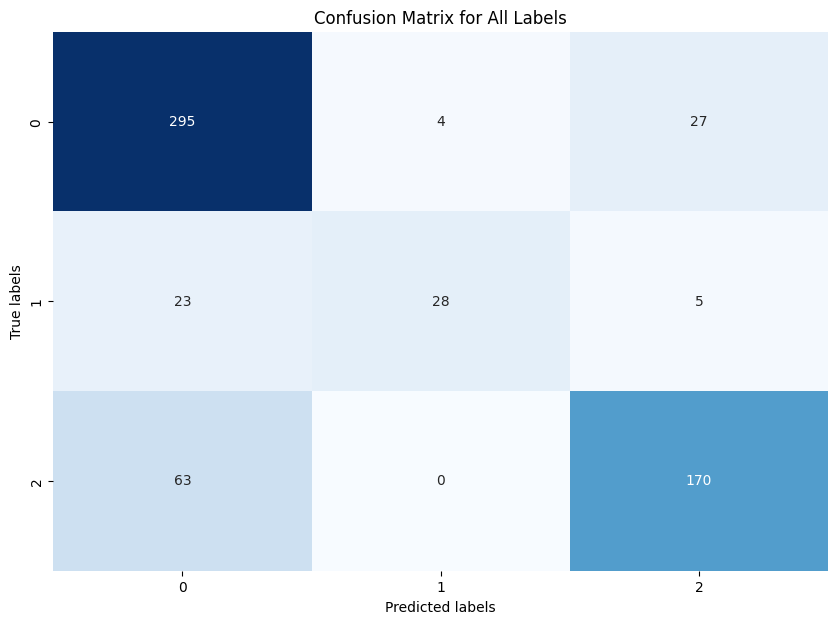

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, knn_y_test_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 5

n=20

In [ ]:
# KNN Model
# fit the training dataset on the classifier
knn_model = KNeighborsClassifier(n_neighbors=20)

# Train the model
knn_model.fit(X_train_tfidf, y_train)

# Predictions
knn_y_train_pred = knn_model.predict(X_train_tfidf)
knn_y_test_pred = knn_model.predict(X_test_tfidf)

# Evaluate KNN model - Use accuracy_score function to get the accuracy
knn_train_accuracy = accuracy_score(y_train, knn_y_train_pred)
knn_test_accuracy = accuracy_score(y_test, knn_y_test_pred)

print("KNN Model:")
print("Train Accuracy:", knn_train_accuracy)
print("Test Accuracy:", knn_test_accuracy)

# Percentage of accuracy
print("KNN Accuracy Score -> ", knn_test_accuracy*100, "%")

KNN Model:
Train Accuracy: 0.8091944670463792
Test Accuracy: 0.8016260162601626
KNN Accuracy Score ->  80.16260162601625 %


In [ ]:
print(metrics.classification_report(y_test, knn_y_test_pred))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       326
           1       0.86      0.54      0.66        56
           2       0.84      0.73      0.78       233

    accuracy                           0.80       615
   macro avg       0.83      0.72      0.76       615
weighted avg       0.81      0.80      0.80       615



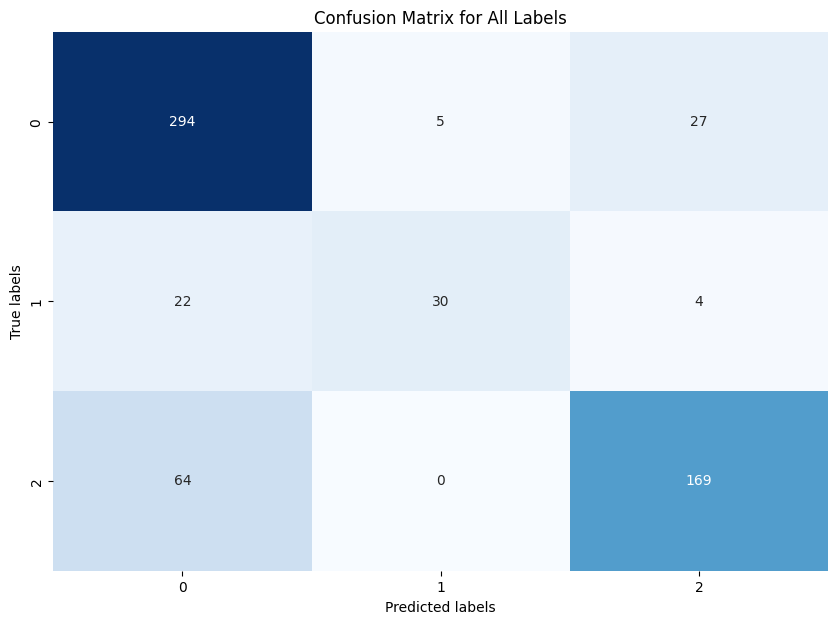

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, knn_y_test_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

## Random Forest Model

###Model 1

max_depth=11, max_features=900, class_weight='balanced'

In [ ]:
# Random Forest Model
# fit the training dataset on the classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=11, max_features=900, random_state=42, class_weight='balanced')

# Train the model
rf_model.fit(X_train_tfidf, y_train)

# Predictions
rf_y_train_pred = rf_model.predict(X_train_tfidf)
rf_y_test_pred = rf_model.predict(X_test_tfidf)

# Evaluate Random Forest model - Use accuracy_score function to get the accuracy
rf_train_accuracy = accuracy_score(y_train, rf_y_train_pred)
rf_test_accuracy = accuracy_score(y_test, rf_y_test_pred)

print("Random Forest Model:")
print("Train Accuracy:", rf_train_accuracy)
print("Test Accuracy:", rf_test_accuracy)

# Percentage of accuracy
print("Random Forest Accuracy Score -> ", rf_test_accuracy*100, "%")

Random Forest Model:
Train Accuracy: 0.9800650935720098
Test Accuracy: 0.9365853658536586
Random Forest Accuracy Score ->  93.65853658536587 %


In [ ]:
print(metrics.classification_report(y_test, rf_y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       326
           1       0.84      0.66      0.74        56
           2       0.98      0.96      0.97       233

    accuracy                           0.94       615
   macro avg       0.91      0.86      0.88       615
weighted avg       0.94      0.94      0.93       615



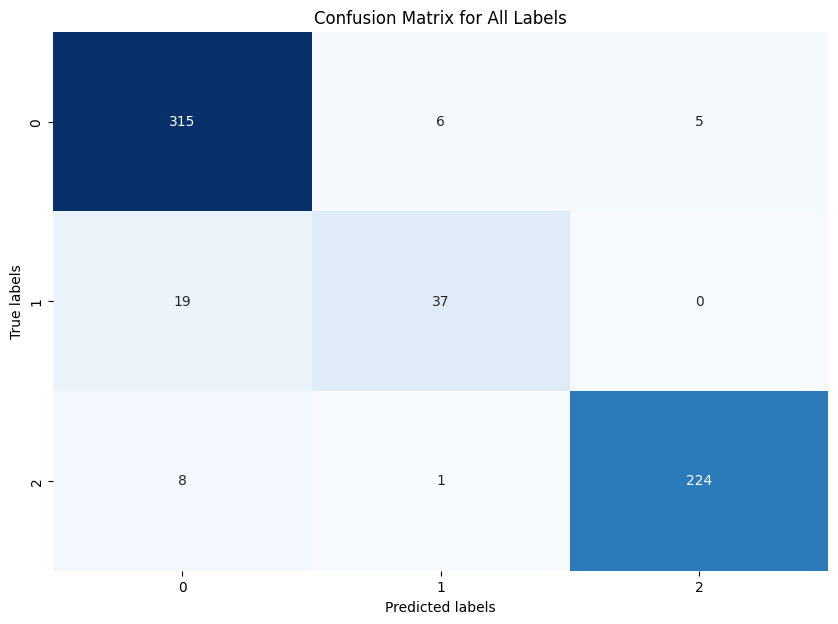

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, rf_y_test_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 2

max_depth=12, max_features=900, class_weight='balanced'

In [ ]:
# Random Forest Model
# fit the training dataset on the classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=12, max_features=900, random_state=42, class_weight='balanced')

# Train the model
rf_model.fit(X_train_tfidf, y_train)

# Predictions
rf_y_train_pred = rf_model.predict(X_train_tfidf)
rf_y_test_pred = rf_model.predict(X_test_tfidf)

# Evaluate Random Forest model - Use accuracy_score function to get the accuracy
rf_train_accuracy = accuracy_score(y_train, rf_y_train_pred)
rf_test_accuracy = accuracy_score(y_test, rf_y_test_pred)

print("Random Forest Model:")
print("Train Accuracy:", rf_train_accuracy)
print("Test Accuracy:", rf_test_accuracy)

# Percentage of accuracy
print("Random Forest Accuracy Score -> ", rf_test_accuracy*100, "%")

Random Forest Model:
Train Accuracy: 0.9796582587469488
Test Accuracy: 0.943089430894309
Random Forest Accuracy Score ->  94.3089430894309 %


In [ ]:
print(metrics.classification_report(y_test, rf_y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       326
           1       0.88      0.80      0.84        56
           2       0.98      0.94      0.96       233

    accuracy                           0.94       615
   macro avg       0.93      0.90      0.92       615
weighted avg       0.94      0.94      0.94       615



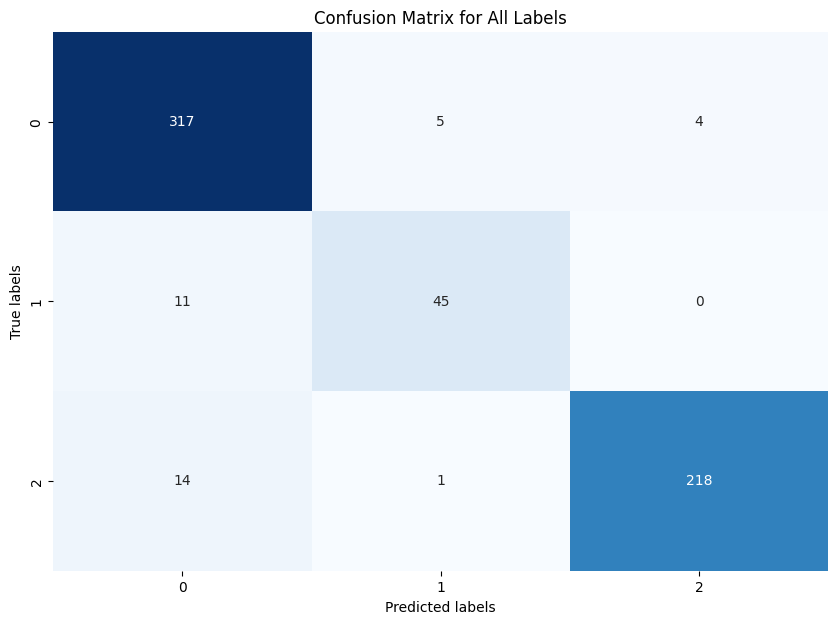

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, rf_y_test_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 3

max_depth=13, max_features=900, class_weight='balanced'

In [ ]:
# Random Forest Model
# fit the training dataset on the classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=13, max_features=900, random_state=42, class_weight='balanced')

# Train the model
rf_model.fit(X_train_tfidf, y_train)

# Predictions
rf_y_train_pred = rf_model.predict(X_train_tfidf)
rf_y_test_pred = rf_model.predict(X_test_tfidf)

# Evaluate Random Forest model - Use accuracy_score function to get the accuracy
rf_train_accuracy = accuracy_score(y_train, rf_y_train_pred)
rf_test_accuracy = accuracy_score(y_test, rf_y_test_pred)

print("Random Forest Model:")
print("Train Accuracy:", rf_train_accuracy)
print("Test Accuracy:", rf_test_accuracy)

# Percentage of accuracy
print("Random Forest Accuracy Score -> ", rf_test_accuracy*100, "%")

Random Forest Model:
Train Accuracy: 0.9808787632221319
Test Accuracy: 0.9382113821138212
Random Forest Accuracy Score ->  93.82113821138212 %


In [ ]:
print(metrics.classification_report(y_test, rf_y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       326
           1       0.88      0.82      0.85        56
           2       0.96      0.94      0.95       233

    accuracy                           0.94       615
   macro avg       0.93      0.91      0.92       615
weighted avg       0.94      0.94      0.94       615



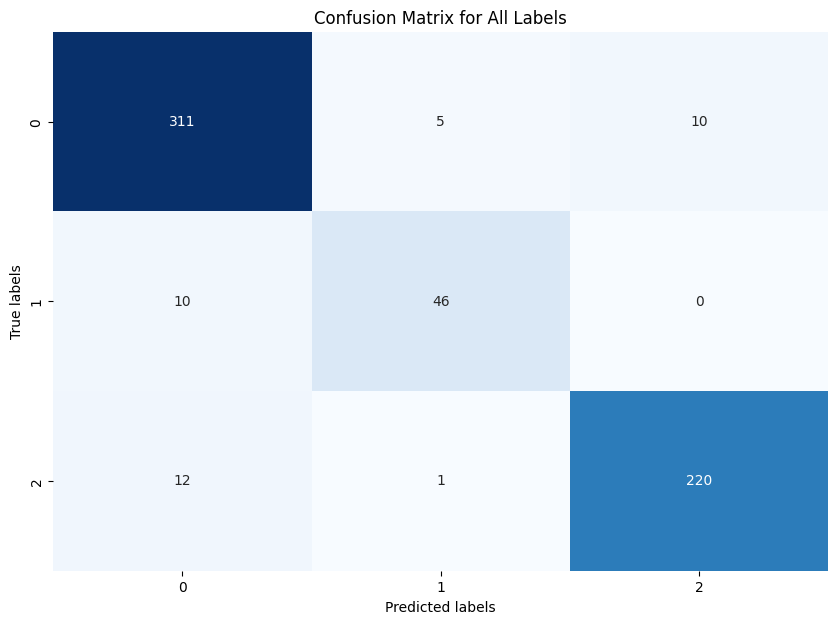

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, rf_y_test_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 4

max_depth=14, max_features=900, class_weight='balanced'

In [ ]:
# Random Forest Model
# fit the training dataset on the classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=14, max_features=900, random_state=42, class_weight='balanced')

# Train the model
rf_model.fit(X_train_tfidf, y_train)

# Predictions
rf_y_train_pred = rf_model.predict(X_train_tfidf)
rf_y_test_pred = rf_model.predict(X_test_tfidf)

# Evaluate Random Forest model - Use accuracy_score function to get the accuracy
rf_train_accuracy = accuracy_score(y_train, rf_y_train_pred)
rf_test_accuracy = accuracy_score(y_test, rf_y_test_pred)

print("Random Forest Model:")
print("Train Accuracy:", rf_train_accuracy)
print("Test Accuracy:", rf_test_accuracy)

# Percentage of accuracy
print("Random Forest Accuracy Score -> ", rf_test_accuracy*100, "%")

Random Forest Model:
Train Accuracy: 0.9825061025223759
Test Accuracy: 0.9398373983739837
Random Forest Accuracy Score ->  93.98373983739837 %


In [ ]:
print(metrics.classification_report(y_test, rf_y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       326
           1       0.89      0.86      0.87        56
           2       0.96      0.94      0.95       233

    accuracy                           0.94       615
   macro avg       0.93      0.92      0.92       615
weighted avg       0.94      0.94      0.94       615



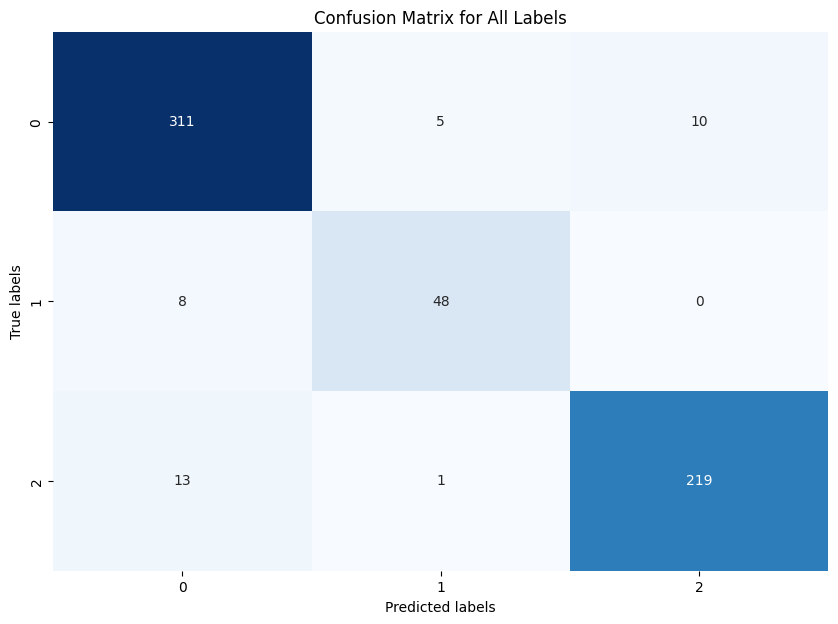

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, rf_y_test_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 5

max_depth=15, max_features=900, class_weight='balanced'

In [ ]:
# Random Forest Model
# fit the training dataset on the classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, max_features=900, random_state=42, class_weight='balanced')

# Train the model
rf_model.fit(X_train_tfidf, y_train)

# Predictions
rf_y_train_pred = rf_model.predict(X_train_tfidf)
rf_y_test_pred = rf_model.predict(X_test_tfidf)

# Evaluate Random Forest model - Use accuracy_score function to get the accuracy
rf_train_accuracy = accuracy_score(y_train, rf_y_train_pred)
rf_test_accuracy = accuracy_score(y_test, rf_y_test_pred)

print("Random Forest Model:")
print("Train Accuracy:", rf_train_accuracy)
print("Test Accuracy:", rf_test_accuracy)

# Percentage of accuracy
print("Random Forest Accuracy Score -> ", rf_test_accuracy*100, "%")

Random Forest Model:
Train Accuracy: 0.983319772172498
Test Accuracy: 0.9252032520325203
Random Forest Accuracy Score ->  92.52032520325203 %


In [ ]:
print(metrics.classification_report(y_test, rf_y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       326
           1       0.88      0.82      0.85        56
           2       0.96      0.91      0.93       233

    accuracy                           0.93       615
   macro avg       0.92      0.89      0.91       615
weighted avg       0.93      0.93      0.92       615



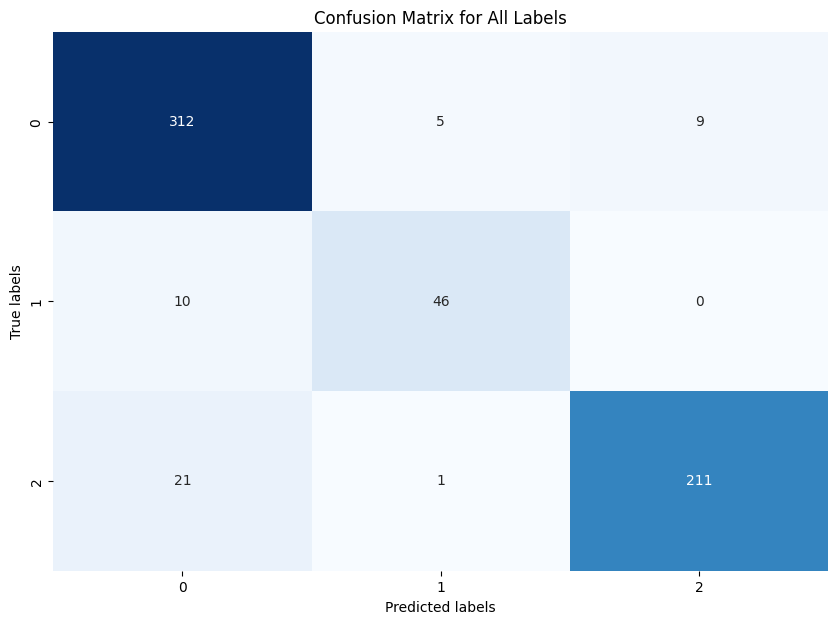

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, rf_y_test_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

## Logistic Regression Model

###Model 1

C=1.0, class_weight='balanced', solver='liblinear'

In [ ]:
# Logistic Regression Model
# Initialize the Naive Bayes classifier
lr_model = LogisticRegression(C=1.0, class_weight='balanced', random_state=42, solver='liblinear')

# fit the training dataset on the classifier and train the model
lr_model.fit(X_train_tfidf, y_train)

# Predictions
lr_y_train_pred = lr_model.predict(X_train_tfidf)
lr_y_test_pred = lr_model.predict(X_test_tfidf)

# Evaluate Logistic Regression model - Use accuracy_score function to get the accuracy
lr_train_accuracy = accuracy_score(y_train, lr_y_train_pred)
lr_test_accuracy = accuracy_score(y_test, lr_y_test_pred)

print("Logistic Regression Model:")
print("Train Accuracy:", lr_train_accuracy)
print("Test Accuracy:", lr_test_accuracy)

# Percentage of accuracy
print("Logistic Regression Accuracy Score -> ", lr_test_accuracy*100, "%")

Logistic Regression Model:
Train Accuracy: 0.9987794955248169
Test Accuracy: 0.9463414634146341
Logistic Regression Accuracy Score ->  94.6341463414634 %


In [ ]:
print(metrics.classification_report(y_test, lr_y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       326
           1       0.92      0.88      0.90        56
           2       0.95      0.95      0.95       233

    accuracy                           0.95       615
   macro avg       0.94      0.93      0.93       615
weighted avg       0.95      0.95      0.95       615



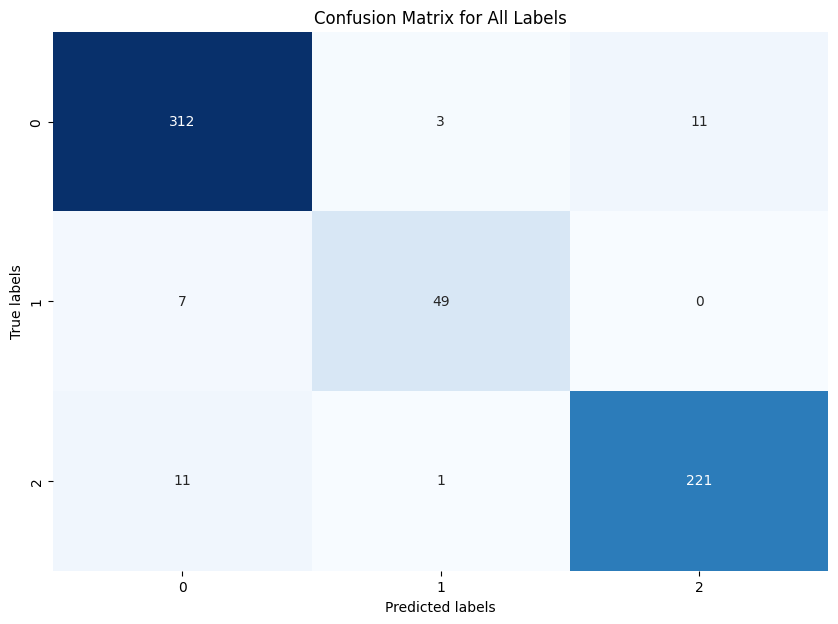

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, y_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 2

C=3.0, class_weight='balanced', solver='liblinear'

In [ ]:
# Logistic Regression Model
# Initialize the Naive Bayes classifier
lr_model = LogisticRegression(C=3.0, class_weight='balanced', random_state=42, solver='liblinear')

# fit the training dataset on the classifier and train the model
lr_model.fit(X_train_tfidf, y_train)

# Predictions
lr_y_train_pred = lr_model.predict(X_train_tfidf)
lr_y_test_pred = lr_model.predict(X_test_tfidf)

# Evaluate Logistic Regression model - Use accuracy_score function to get the accuracy
lr_train_accuracy = accuracy_score(y_train, lr_y_train_pred)
lr_test_accuracy = accuracy_score(y_test, lr_y_test_pred)

print("Logistic Regression Model:")
print("Train Accuracy:", lr_train_accuracy)
print("Test Accuracy:", lr_test_accuracy)

# Percentage of accuracy
print("Logistic Regression Accuracy Score -> ", lr_test_accuracy*100, "%")

Logistic Regression Model:
Train Accuracy: 1.0
Test Accuracy: 0.9528455284552846
Logistic Regression Accuracy Score ->  95.28455284552845 %


In [ ]:
print(metrics.classification_report(y_test, lr_y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       326
           1       0.88      0.93      0.90        56
           2       0.94      0.97      0.96       233

    accuracy                           0.95       615
   macro avg       0.93      0.95      0.94       615
weighted avg       0.95      0.95      0.95       615



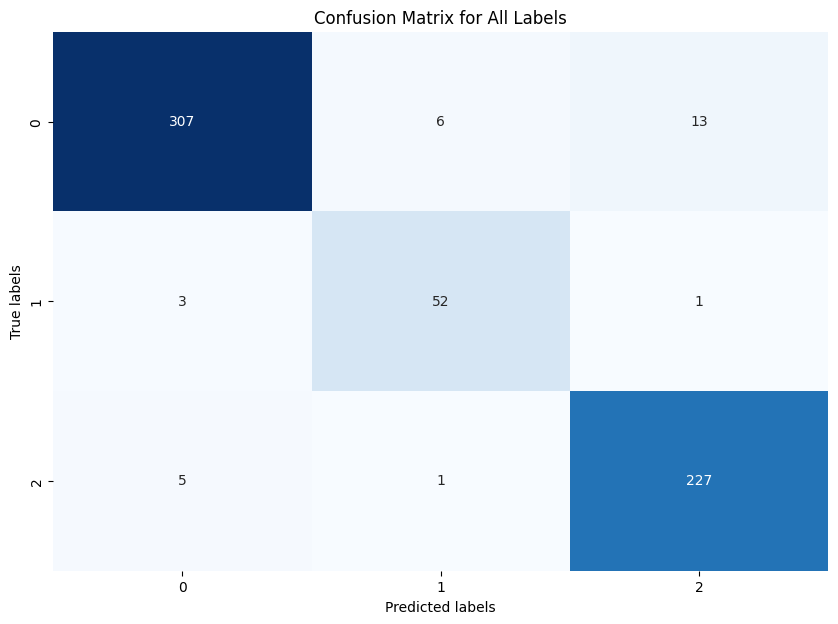

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, y_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 3

C=5.0, class_weight='balanced', solver='liblinear'

In [ ]:
# Logistic Regression Model
# Initialize the Naive Bayes classifier
lr_model = LogisticRegression(C=5.0, class_weight='balanced', random_state=42, solver='liblinear')

# fit the training dataset on the classifier and train the model
lr_model.fit(X_train_tfidf, y_train)

# Predictions
lr_y_train_pred = lr_model.predict(X_train_tfidf)
lr_y_test_pred = lr_model.predict(X_test_tfidf)

# Evaluate Logistic Regression model - Use accuracy_score function to get the accuracy
lr_train_accuracy = accuracy_score(y_train, lr_y_train_pred)
lr_test_accuracy = accuracy_score(y_test, lr_y_test_pred)

print("Logistic Regression Model:")
print("Train Accuracy:", lr_train_accuracy)
print("Test Accuracy:", lr_test_accuracy)

# Percentage of accuracy
print("Logistic Regression Accuracy Score -> ", lr_test_accuracy*100, "%")

Logistic Regression Model:
Train Accuracy: 1.0
Test Accuracy: 0.9512195121951219
Logistic Regression Accuracy Score ->  95.1219512195122 %


In [ ]:
print(metrics.classification_report(y_test, lr_y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96       326
           1       0.87      0.93      0.90        56
           2       0.93      0.98      0.96       233

    accuracy                           0.95       615
   macro avg       0.93      0.95      0.94       615
weighted avg       0.95      0.95      0.95       615



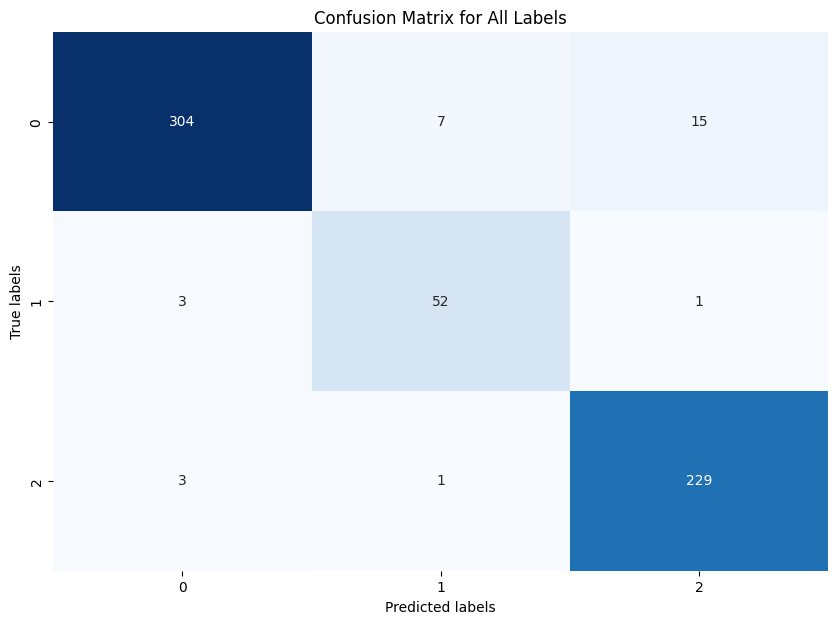

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, y_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 4

C=1.0, class_weight='balanced', solver='lbfgs'

In [ ]:
# Logistic Regression Model
# Initialize the Naive Bayes classifier
lr_model = LogisticRegression(C=1.0, class_weight='balanced', random_state=42)

# fit the training dataset on the classifier and train the model
lr_model.fit(X_train_tfidf, y_train)

# Predictions
lr_y_train_pred = lr_model.predict(X_train_tfidf)
lr_y_test_pred = lr_model.predict(X_test_tfidf)

# Evaluate Logistic Regression model - Use accuracy_score function to get the accuracy
lr_train_accuracy = accuracy_score(y_train, lr_y_train_pred)
lr_test_accuracy = accuracy_score(y_test, lr_y_test_pred)

print("Logistic Regression Model:")
print("Train Accuracy:", lr_train_accuracy)
print("Test Accuracy:", lr_test_accuracy)

# Percentage of accuracy
print("Logistic Regression Accuracy Score -> ", lr_test_accuracy*100, "%")

Logistic Regression Model:
Train Accuracy: 0.999593165174939
Test Accuracy: 0.9333333333333333
Logistic Regression Accuracy Score ->  93.33333333333333 %


In [ ]:
print(metrics.classification_report(y_test, lr_y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       326
           1       0.81      0.96      0.88        56
           2       0.91      0.97      0.94       233

    accuracy                           0.93       615
   macro avg       0.90      0.95      0.92       615
weighted avg       0.94      0.93      0.93       615



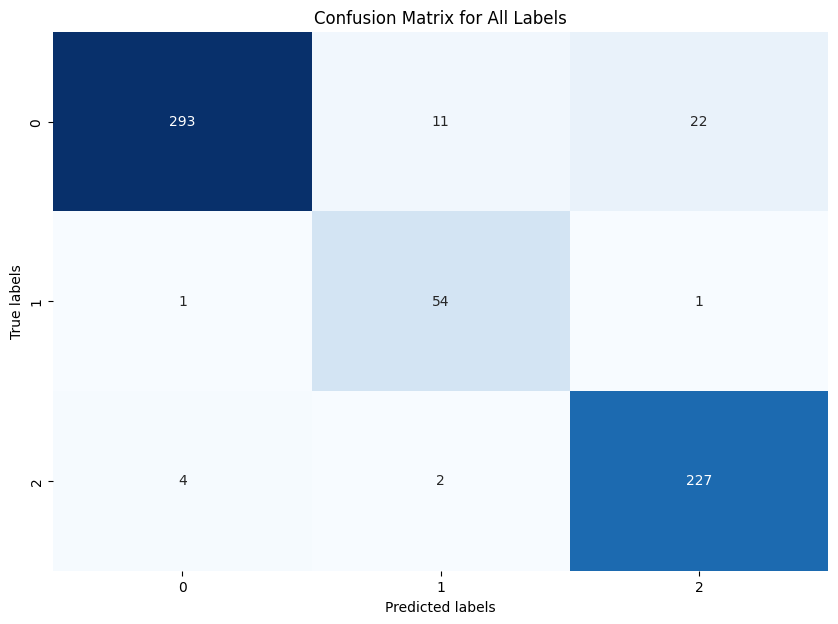

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, y_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 5

C=3.0, class_weight='balanced', solver='lbfgs'

In [ ]:
# Logistic Regression Model
# Initialize the Naive Bayes classifier
lr_model = LogisticRegression(C=3.0, class_weight='balanced', random_state=42)

# fit the training dataset on the classifier and train the model
lr_model.fit(X_train_tfidf, y_train)

# Predictions
lr_y_train_pred = lr_model.predict(X_train_tfidf)
lr_y_test_pred = lr_model.predict(X_test_tfidf)

# Evaluate Logistic Regression model - Use accuracy_score function to get the accuracy
lr_train_accuracy = accuracy_score(y_train, lr_y_train_pred)
lr_test_accuracy = accuracy_score(y_test, lr_y_test_pred)

print("Logistic Regression Model:")
print("Train Accuracy:", lr_train_accuracy)
print("Test Accuracy:", lr_test_accuracy)

# Percentage of accuracy
print("Logistic Regression Accuracy Score -> ", lr_test_accuracy*100, "%")

Logistic Regression Model:
Train Accuracy: 1.0
Test Accuracy: 0.9414634146341463
Logistic Regression Accuracy Score ->  94.14634146341463 %


In [ ]:
print(metrics.classification_report(y_test, lr_y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       326
           1       0.83      0.95      0.88        56
           2       0.92      0.98      0.95       233

    accuracy                           0.94       615
   macro avg       0.91      0.95      0.93       615
weighted avg       0.95      0.94      0.94       615



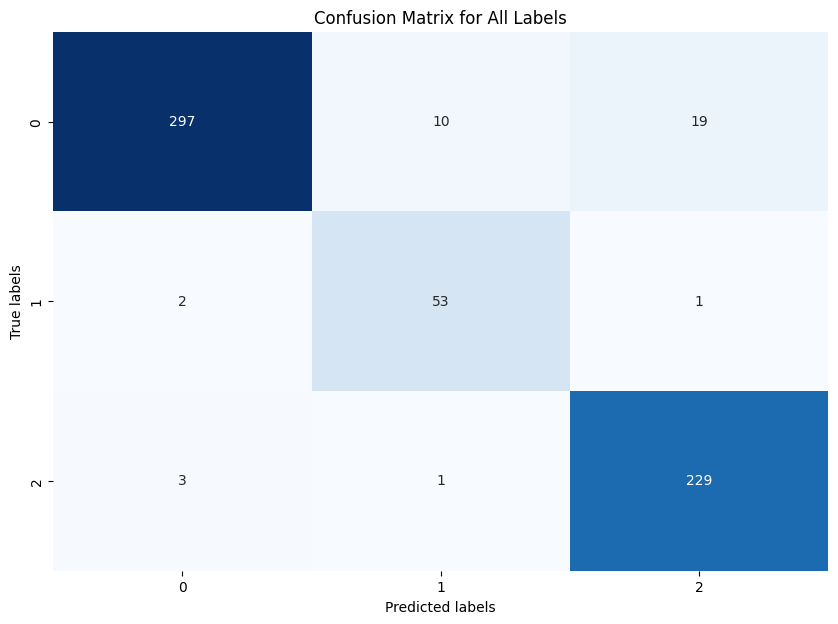

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, y_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()

###Model 6

C=5.0, class_weight='balanced', solver='lbfgs'

In [ ]:
# Logistic Regression Model
# Initialize the Naive Bayes classifier
lr_model = LogisticRegression(C=5.0, class_weight='balanced', random_state=42)

# fit the training dataset on the classifier and train the model
lr_model.fit(X_train_tfidf, y_train)

# Predictions
lr_y_train_pred = lr_model.predict(X_train_tfidf)
lr_y_test_pred = lr_model.predict(X_test_tfidf)

# Evaluate Logistic Regression model - Use accuracy_score function to get the accuracy
lr_train_accuracy = accuracy_score(y_train, lr_y_train_pred)
lr_test_accuracy = accuracy_score(y_test, lr_y_test_pred)

print("Logistic Regression Model:")
print("Train Accuracy:", lr_train_accuracy)
print("Test Accuracy:", lr_test_accuracy)

# Percentage of accuracy
print("Logistic Regression Accuracy Score -> ", lr_test_accuracy*100, "%")

Logistic Regression Model:
Train Accuracy: 1.0
Test Accuracy: 0.9414634146341463
Logistic Regression Accuracy Score ->  94.14634146341463 %


In [ ]:
print(metrics.classification_report(y_test, lr_y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       326
           1       0.83      0.95      0.88        56
           2       0.92      0.98      0.95       233

    accuracy                           0.94       615
   macro avg       0.91      0.95      0.93       615
weighted avg       0.95      0.94      0.94       615



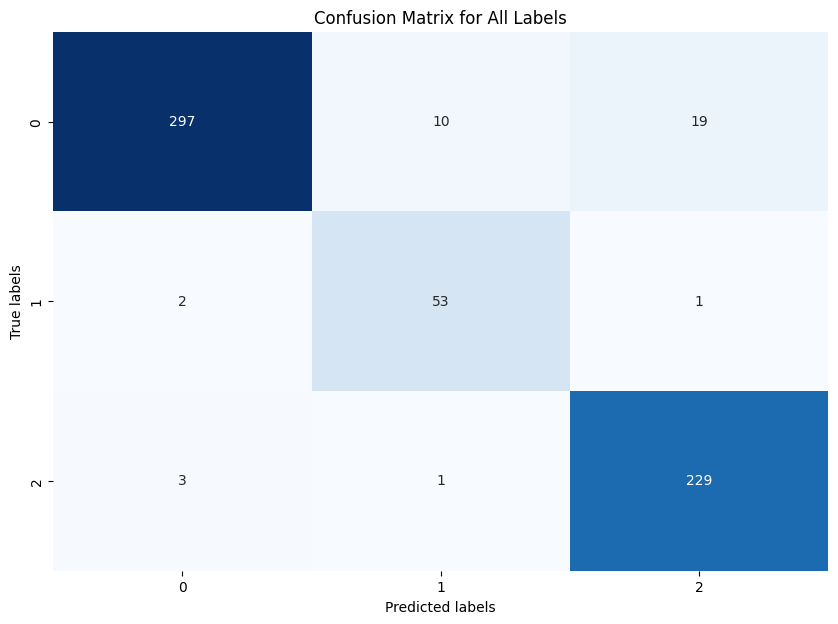

In [ ]:
# Compute confusion matrix for all labels
cm = confusion_matrix(y_test, y_pred)

# Plot the combined confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for All Labels')
plt.show()